In [1]:
# Exoplanet Habitability Prediction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Load Data
df = pd.read_csv(
    "../data/PSCompPars_2025.12.15_07.37.02.csv",
    comment="#"
)

print(f"Initial dataset shape: {df.shape}")
print(f"Columns: {df.shape[1]}\n")

# Select Relevant Features
features = [
    "pl_name",
    "pl_rade",      # planet radius (Earth radii)
    "pl_bmasse",    # planet mass (Earth mass)
    "pl_orbper",    # orbital period (days)
    "pl_orbsmax",   # semi-major axis (AU)
    "pl_eqt",       # equilibrium temperature (K)
    "pl_insol",     # stellar flux (Earth flux)
    "st_teff",      # star temperature (K)
    "st_rad",       # star radius (Solar radii)
    "st_met"        # star metallicity (dex)
]

df = df[features].copy()
print(f"After feature selection: {df.shape}")
print(f"\nFeature Metadata:")
print("-" * 50)
for feat in features[1:]:  # Skip pl_name
    print(f"{feat}: {df[feat].dtype}")
df.head()


Initial dataset shape: (6061, 84)
Columns: 84

After feature selection: (6061, 10)

Feature Metadata:
--------------------------------------------------
pl_rade: float64
pl_bmasse: float64
pl_orbper: float64
pl_orbsmax: float64
pl_eqt: float64
pl_insol: float64
st_teff: float64
st_rad: float64
st_met: float64


,pl_name,pl_rade,pl_bmasse,pl_orbper,pl_orbsmax,pl_eqt,pl_insol,st_teff,st_rad,st_met
0,11 Com b,12.2,4914.898486,323.21000,1.178,NaN,NaN,4874.0,13.76,-0.2600
1,11 UMi b,12.3,4684.814200,516.21997,1.530,NaN,NaN,4213.0,29.79,-0.0200
2,14 And b,13.1,1131.151301,186.76000,0.775,NaN,NaN,4888.0,11.55,-0.2100
3,14 Her b,12.6,2559.472162,1765.03890,2.774,NaN,NaN,5338.0,0.93,0.4052
4,16 Cyg B b,13.5,565.737400,798.50000,1.660,NaN,NaN,5750.0,1.13,0.0600


MISSING VALUE ANALYSIS

Missing Values by Feature:
   Feature  Missing_Count  Missing_Percentage Data_Type
  pl_insol           1806           29.797063   float64
    pl_eqt           1535           25.325854   float64
    st_met            532            8.777429   float64
 pl_orbper            317            5.230160   float64
pl_orbsmax            303            4.999175   float64
    st_rad            298            4.916680   float64
   st_teff            276            4.553704   float64
   pl_rade             50            0.824946   float64
 pl_bmasse             31            0.511467   float64
   pl_name              0            0.000000    object


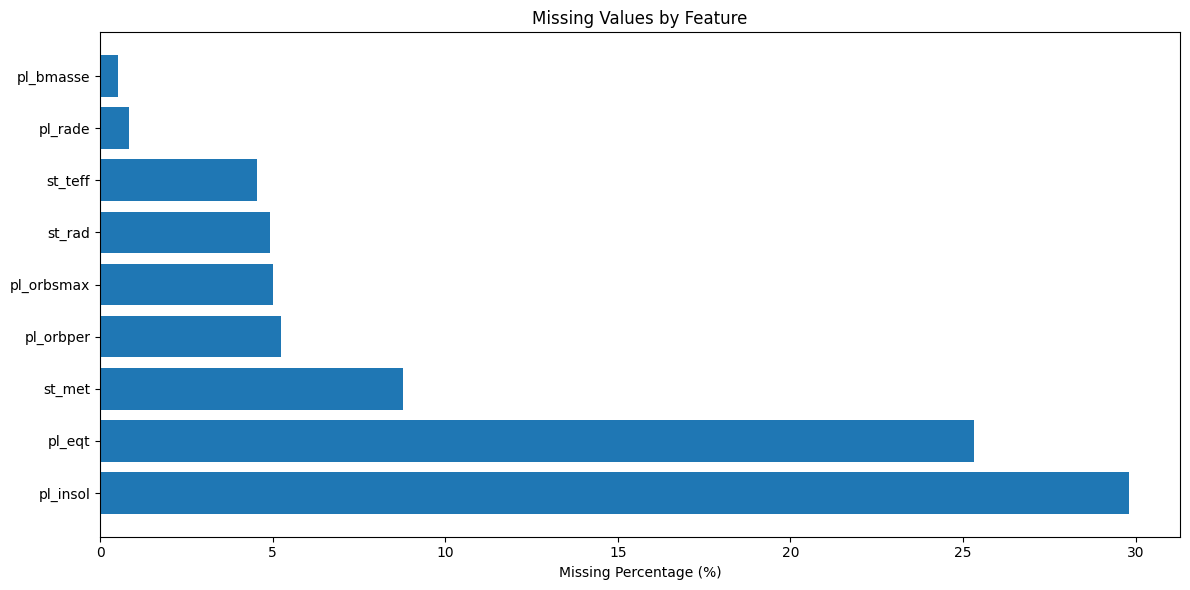

In [3]:
#Missing Value Analysis

print("MISSING VALUE ANALYSIS")

missing_analysis = pd.DataFrame({
    'Feature': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
    'Data_Type': df.dtypes
})

missing_analysis = missing_analysis.sort_values('Missing_Percentage', ascending=False)
print("\nMissing Values by Feature:")
print(missing_analysis.to_string(index=False))

# Visualize missing values
plt.figure(figsize=(12, 6))
missing_analysis_nonzero = missing_analysis[missing_analysis['Missing_Percentage'] > 0]
if len(missing_analysis_nonzero) > 0:
    plt.barh(missing_analysis_nonzero['Feature'], missing_analysis_nonzero['Missing_Percentage'])
    plt.xlabel('Missing Percentage (%)')
    plt.title('Missing Values by Feature')
    plt.tight_layout()
    plt.show()
else:
    print("\n✓ No missing values found in selected features!")


DESCRIPTIVE STATISTICS

Numerical Features Summary:
             count          mean           std         min          25%  \
pl_rade     6011.0      5.819677  5.347059e+00    0.309800     1.820000   
pl_bmasse   6030.0    401.663284  1.131683e+03    0.020000     4.182500   
pl_orbper   5744.0  74505.121388  5.306667e+06    0.090706     4.347374   
pl_orbsmax  5758.0     15.684098  3.511903e+02    0.004400     0.052393   
pl_eqt      4526.0    915.795466  4.647422e+02   34.000000   569.000000   
pl_insol    4255.0    422.947653  1.320606e+03    0.000300    24.031500   
st_teff     5785.0   5406.929983  1.751654e+03  415.000000  4914.000000   
st_rad      5763.0      1.511773  3.974061e+00    0.011500     0.771120   
st_met      5529.0      0.015330  1.882315e-01   -1.000000    -0.080000   

                    50%          75%           max  
pl_rade        2.830000    11.954398  7.734210e+01  
pl_bmasse      9.213512   190.294585  9.534852e+03  
pl_orbper     11.109275    39.762740  

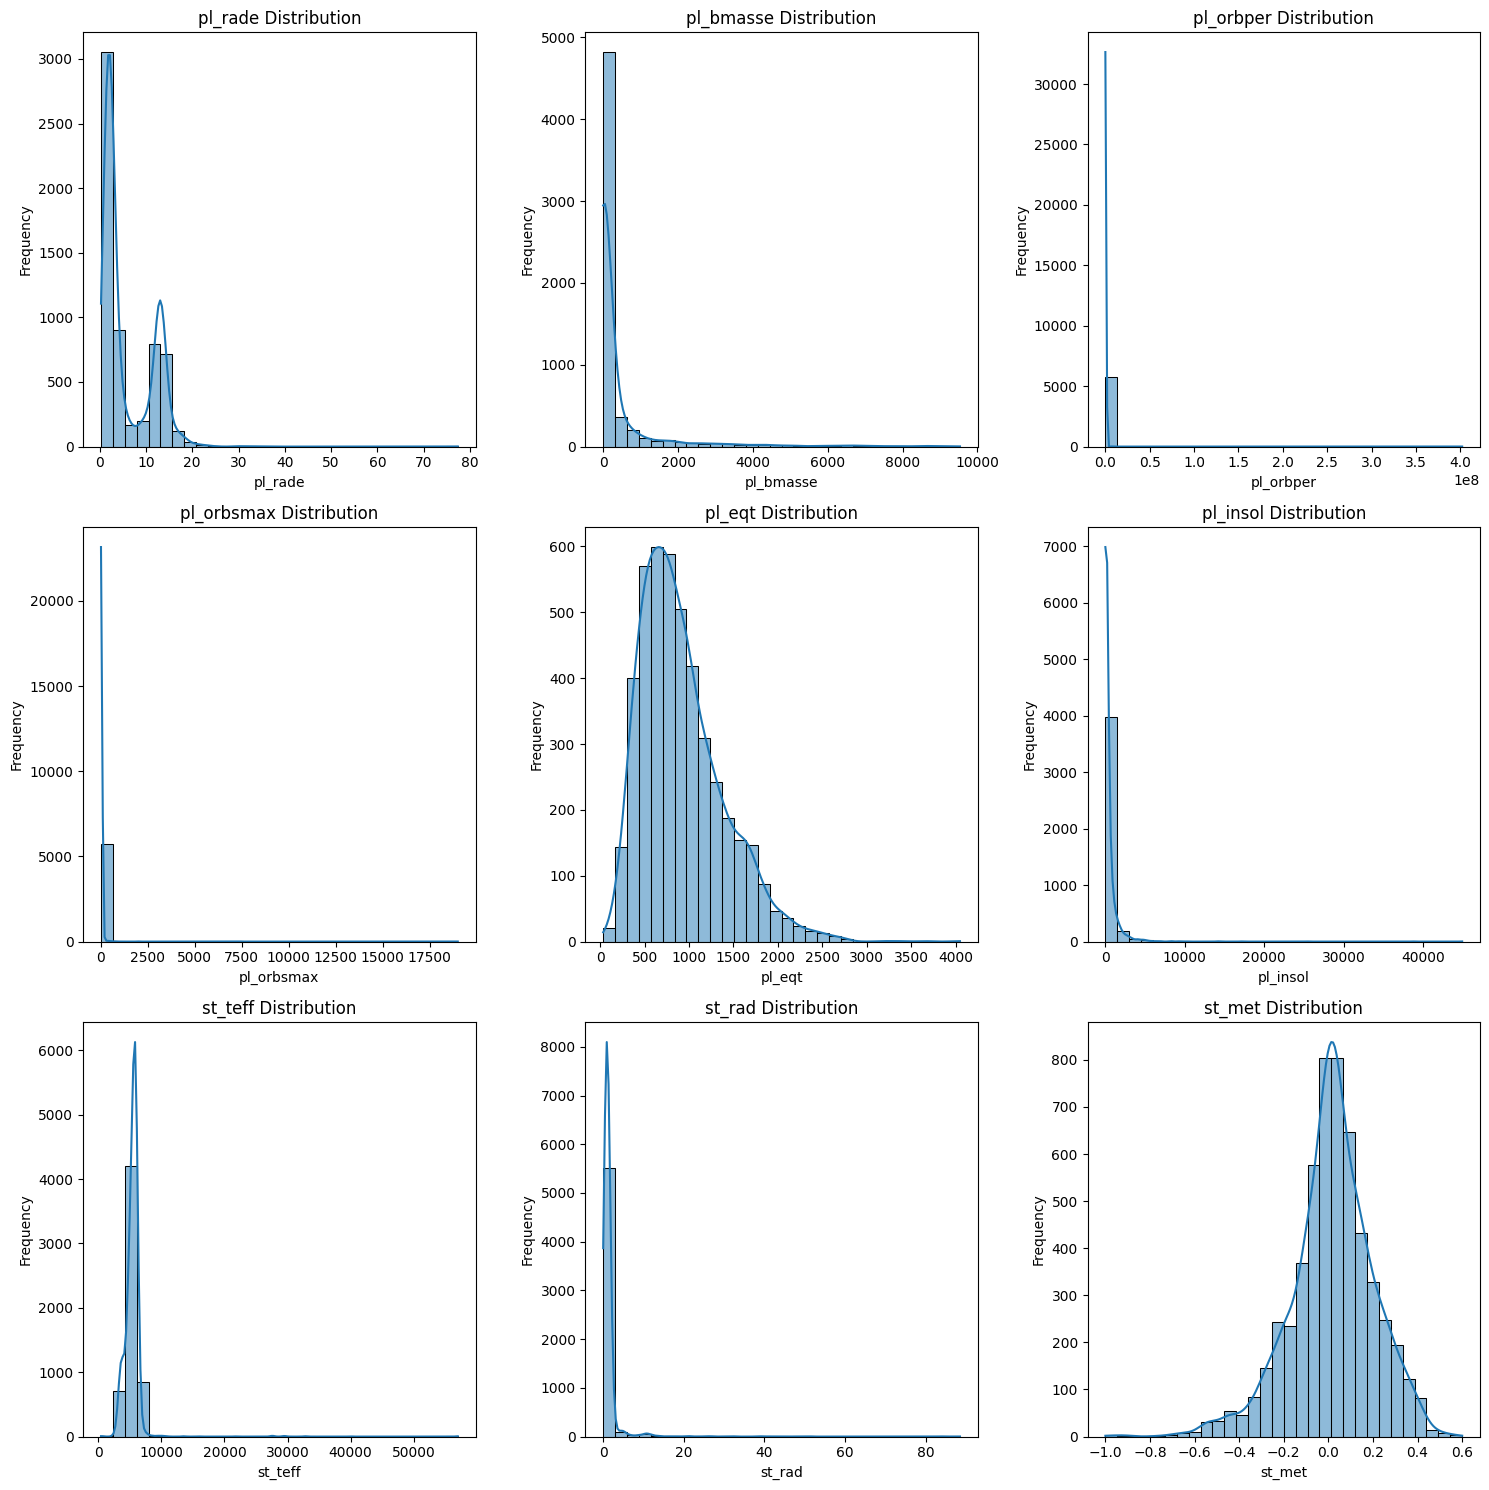

In [4]:
#Descriptive Statistics for All Features

print("DESCRIPTIVE STATISTICS")

numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
if 'pl_name' in numeric_features:
    numeric_features.remove('pl_name')

print("\nNumerical Features Summary:")
print(df[numeric_features].describe().T)

# Distribution plots for all numerical features
n_features = len(numeric_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for idx, feat in enumerate(numeric_features):
    if idx < len(axes):
        sns.histplot(df[feat], kde=True, ax=axes[idx], bins=30)
        axes[idx].set_title(f'{feat} Distribution')
        axes[idx].set_xlabel(feat)
        axes[idx].set_ylabel('Frequency')

# Hide extra subplots
for idx in range(len(numeric_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()


OUTLIER DETECTION - IQR Method

Outlier Summary:
   Feature          Q1          Q3        IQR  Lower_Bound  Upper_Bound  Outliers_Count  Outliers_Percentage
   pl_rade    1.820000   11.954398  10.134398   -13.381598    27.155996               6             0.098994
 pl_bmasse    4.182500  190.294585 186.112085  -274.985628   469.462713             992            16.366936
 pl_orbper    4.347374   39.762740  35.415366   -48.775675    92.885789            1003            16.548424
pl_orbsmax    0.052393    0.301925   0.249532    -0.321906     0.676224            1047            17.274377
    pl_eqt  569.000000 1166.000000 597.000000  -326.500000  2061.500000              98             1.616895
  pl_insol   24.031500  381.732500 357.701000  -512.520000   918.284000             499             8.232965
   st_teff 4914.000000 5900.000000 986.000000  3435.000000  7379.000000             273             4.504207
    st_rad    0.771120    1.250000   0.478880     0.052800     1.968320        

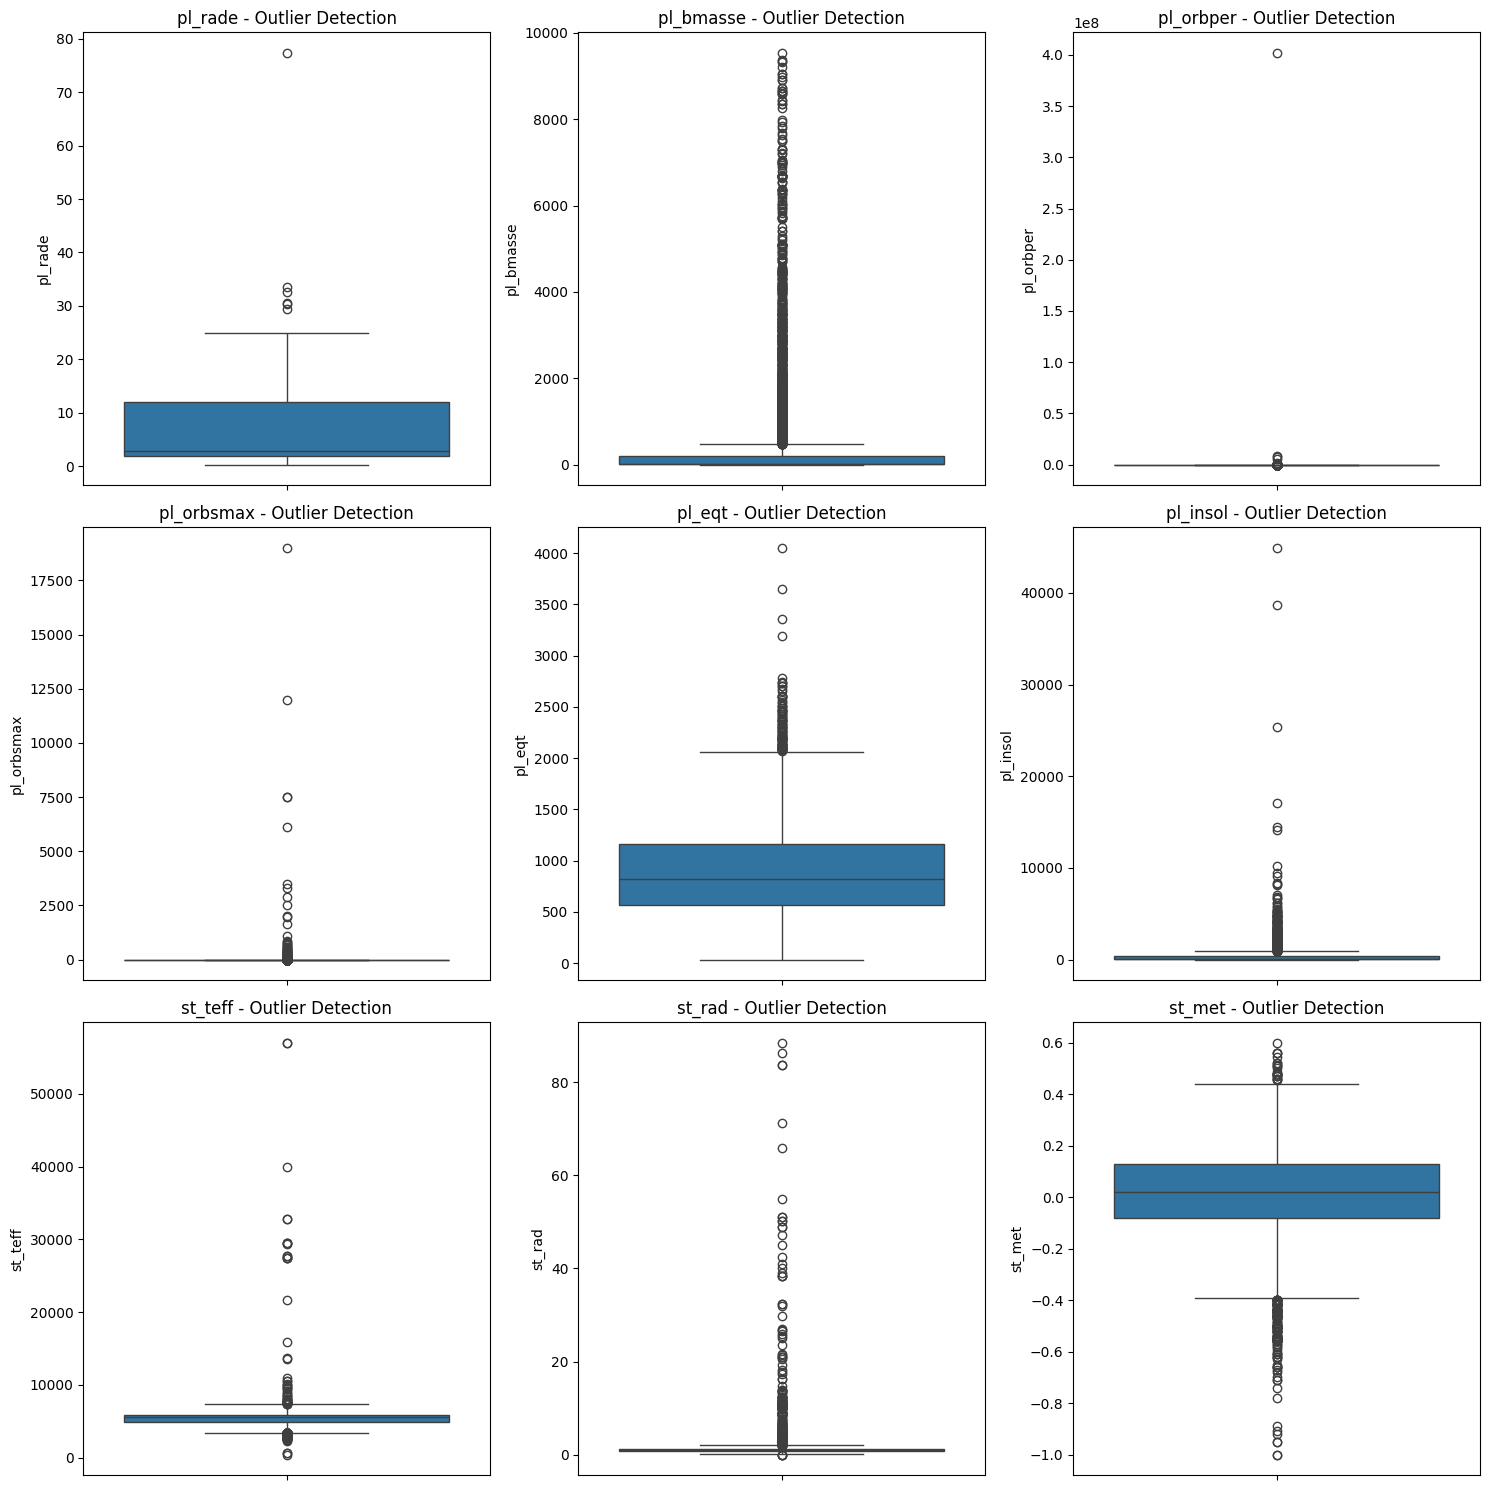

In [5]:
#Outlier Detection Using IQR Method

print("OUTLIER DETECTION - IQR Method")

outlier_summary = []

for col in numeric_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    n_outliers = len(outliers)
    pct_outliers = (n_outliers / len(df)) * 100
    
    outlier_summary.append({
        'Feature': col,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound,
        'Outliers_Count': n_outliers,
        'Outliers_Percentage': pct_outliers
    })

outlier_df = pd.DataFrame(outlier_summary)
print("\nOutlier Summary:")
print(outlier_df.to_string(index=False))

# Boxplots for outlier visualization
n_cols = 3
n_rows = (len(numeric_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for idx, feat in enumerate(numeric_features):
    if idx < len(axes):
        sns.boxplot(y=df[feat], ax=axes[idx])
        axes[idx].set_title(f'{feat} - Outlier Detection')
        axes[idx].set_ylabel(feat)

for idx in range(len(numeric_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()


In [6]:
#Handle Missing Values

print("DATA CLEANING - MISSING VALUES")

df_cleaned = df.copy()

# Drop rows with missing critical features
critical_features = ["pl_rade", "pl_bmasse", "pl_eqt", "st_teff"]
print(f"\nBefore dropping missing critical features: {len(df_cleaned)} rows")
df_cleaned = df_cleaned.dropna(subset=critical_features)
print(f"After dropping missing critical features: {len(df_cleaned)} rows")

# Fill remaining missing values with median for numerical features
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_cleaned[col].isnull().sum() > 0:
        median_val = df_cleaned[col].median()
        df_cleaned[col].fillna(median_val, inplace=True)
        print(f"  Filled {col} with median: {median_val:.4f}")

print(f"\n✓ Missing values handled. Final shape: {df_cleaned.shape}")


DATA CLEANING - MISSING VALUES

Before dropping missing critical features: 6061 rows
After dropping missing critical features: 4483 rows
  Filled pl_orbper with median: 8.4578
  Filled pl_orbsmax with median: 0.0787
  Filled pl_insol with median: 101.3265
  Filled st_rad with median: 0.9400
  Filled st_met with median: 0.0200

✓ Missing values handled. Final shape: (4483, 10)


In [7]:
#Handle Outliers - Replace with Median

print("DATA CLEANING - OUTLIER HANDLING")

df_cleaned = df_cleaned.copy()
outliers_replaced = {}

for col in numeric_features:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers
    n_outliers = ((df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)).sum()
    
    if n_outliers > 0:
        # Replace outliers with median
        median_val = df_cleaned[col].median()
        df_cleaned.loc[df_cleaned[col] < lower_bound, col] = median_val
        df_cleaned.loc[df_cleaned[col] > upper_bound, col] = median_val
        outliers_replaced[col] = n_outliers
        print(f"  {col}: Replaced {n_outliers} outliers with median ({median_val:.4f})")

if outliers_replaced:
    print(f"\n✓ Outliers replaced in {len(outliers_replaced)} features")
else:
    print("\n✓ No outliers found or already handled")

print(f"Final dataset shape: {df_cleaned.shape}")
df = df_cleaned.copy()  # Update main dataframe


DATA CLEANING - OUTLIER HANDLING
  pl_rade: Replaced 880 outliers with median (2.4800)
  pl_bmasse: Replaced 932 outliers with median (7.2200)
  pl_orbper: Replaced 541 outliers with median (8.4578)
  pl_orbsmax: Replaced 466 outliers with median (0.0787)
  pl_eqt: Replaced 97 outliers with median (822.0000)
  pl_insol: Replaced 573 outliers with median (101.3265)
  st_teff: Replaced 277 outliers with median (5596.0000)
  st_rad: Replaced 187 outliers with median (0.9400)
  st_met: Replaced 220 outliers with median (0.0200)

✓ Outliers replaced in 9 features
Final dataset shape: (4483, 10)


In [8]:
#Feature Engineering

print("FEATURE ENGINEERING")

# Planet density
df["planet_density"] = df["pl_bmasse"] / (df["pl_rade"] ** 3)
print("✓ Created: planet_density = mass / (radius³)")

# Star luminosity (using Stefan-Boltzmann law)
df["star_luminosity"] = (df["st_rad"] ** 2) * ((df["st_teff"] / 5778) ** 4)
print("✓ Created: star_luminosity = (radius²) × (temp/5778)⁴")

# Star type classification
def star_type(teff):
    if pd.isna(teff):
        return "M"
    if teff > 7500:
        return "A"
    elif teff > 6000:
        return "F"
    elif teff > 5200:
        return "G"
    elif teff > 3700:
        return "K"
    else:
        return "M"

df["star_type"] = df["st_teff"].apply(star_type)
print("✓ Created: star_type (A, F, G, K, M)")

# Habitability Score Index (HSI)
df["HSI"] = (
    (1 - abs(df["pl_rade"] - 1)) *
    (1 - abs(df["pl_eqt"] - 288) / 288) *
    (1 / (1 + df["pl_insol"].fillna(0)))
).clip(0, 1)
print("✓ Created: HSI (Habitability Score Index)")

# Stellar Compatibility Index (SCI)
df["SCI"] = (
    (1 / (1 + abs(df["st_teff"] - 5778))) *
    (1 / (1 + abs(df["st_met"].fillna(0))))
).clip(0, 1)
print("✓ Created: SCI (Stellar Compatibility Index)")

# One-hot encode star type
df = pd.get_dummies(df, columns=["star_type"], drop_first=True)
print("✓ One-hot encoded: star_type")

# Filter based on physical constraints
print(f"\nBefore filtering: {len(df)} rows")
df = df[(df["pl_rade"] < 2.5) & (df["pl_eqt"] < 500)]
print(f"After filtering (radius < 2.5, temp < 500K): {len(df)} rows")

# Create target variable (habitable)
def is_habitable(row):
    """Define habitability based on physical constraints"""
    if (
        180 <= row["pl_eqt"] <= 310 and
        0.5 <= row["pl_rade"] <= 2.0 and
        0.25 <= row["pl_insol"] <= 1.5
    ):
        return 1
    else:
        return 0

df["habitable"] = df.apply(is_habitable, axis=1)
print("✓ Created: habitable (target variable)")

print(f"\nFinal dataset shape: {df.shape}")
print(f"Habitable planets: {df['habitable'].sum()}")
print(f"Non-habitable planets: {(df['habitable'] == 0).sum()}")
print(f"Class balance: {df['habitable'].value_counts(normalize=True).to_dict()}")


FEATURE ENGINEERING
✓ Created: planet_density = mass / (radius³)
✓ Created: star_luminosity = (radius²) × (temp/5778)⁴
✓ Created: star_type (A, F, G, K, M)
✓ Created: HSI (Habitability Score Index)
✓ Created: SCI (Stellar Compatibility Index)
✓ One-hot encoded: star_type

Before filtering: 4483 rows
After filtering (radius < 2.5, temp < 500K): 468 rows
✓ Created: habitable (target variable)

Final dataset shape: (468, 18)
Habitable planets: 33
Non-habitable planets: 435
Class balance: {0: 0.9294871794871795, 1: 0.07051282051282051}


CLASS IMBALANCE ANALYSIS

Class Distribution:
  Non-Habitable (0): 435 (92.95%)
  Habitable (1):     33 (7.05%)
  Imbalance Ratio:   13.18:1


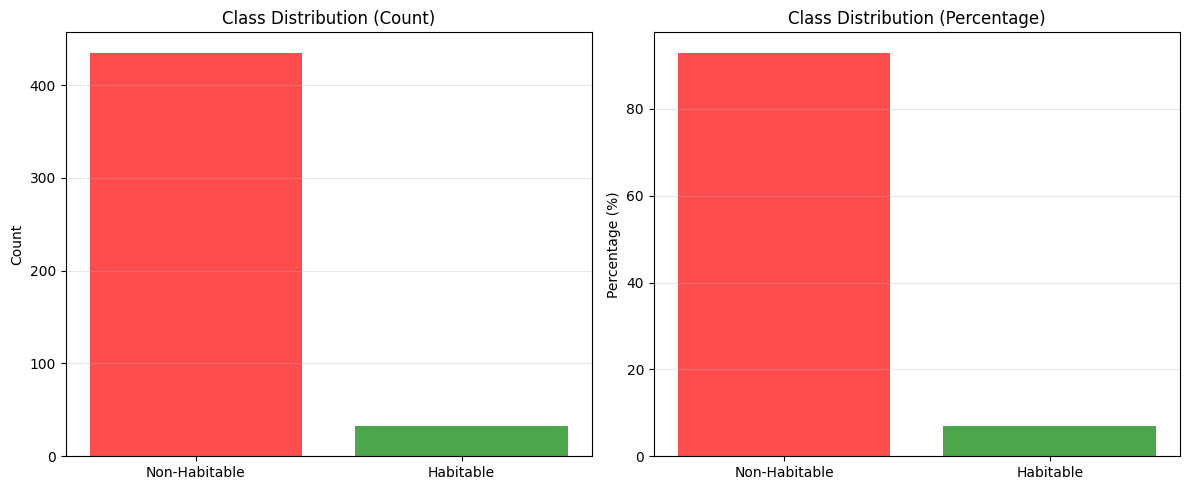

In [9]:
#Class Imbalance Analysis


print("CLASS IMBALANCE ANALYSIS")

class_dist = df['habitable'].value_counts()
class_dist_pct = df['habitable'].value_counts(normalize=True) * 100

print(f"\nClass Distribution:")
print(f"  Non-Habitable (0): {class_dist[0]} ({class_dist_pct[0]:.2f}%)")
print(f"  Habitable (1):     {class_dist[1]} ({class_dist_pct[1]:.2f}%)")
print(f"  Imbalance Ratio:   {class_dist[0]/class_dist[1]:.2f}:1")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
axes[0].bar(['Non-Habitable', 'Habitable'], [class_dist[0], class_dist[1]], 
            color=['red', 'green'], alpha=0.7)
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution (Count)')
axes[0].grid(axis='y', alpha=0.3)

# Percentage plot
axes[1].bar(['Non-Habitable', 'Habitable'], [class_dist_pct[0], class_dist_pct[1]], 
            color=['red', 'green'], alpha=0.7)
axes[1].set_ylabel('Percentage (%)')
axes[1].set_title('Class Distribution (Percentage)')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


FEATURE CORRELATION ANALYSIS


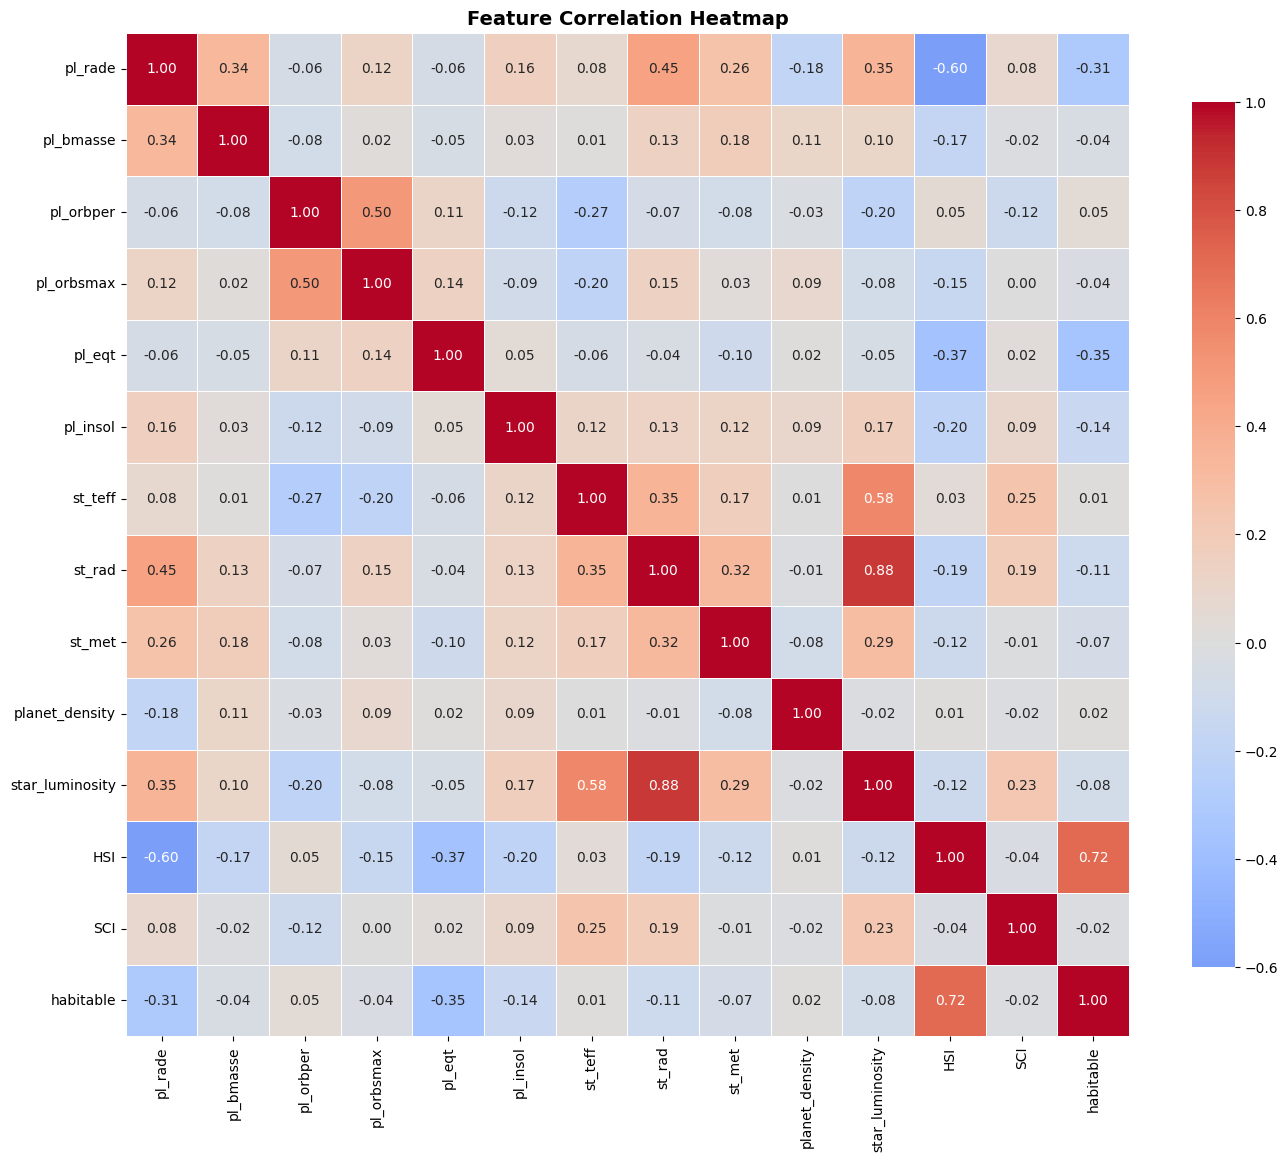


Correlation with Target (habitable):
habitable          1.000000
HSI                0.717404
pl_orbper          0.048851
planet_density     0.018400
st_teff            0.013571
SCI               -0.015270
pl_orbsmax        -0.035402
pl_bmasse         -0.041327
st_met            -0.067078
star_luminosity   -0.076468
st_rad            -0.109825
pl_insol          -0.139313
pl_rade           -0.308344
pl_eqt            -0.352584


In [10]:
#Feature-Level EDA - Correlation Heatmap
print("FEATURE CORRELATION ANALYSIS")

# Select numerical features for correlation
corr_features = df.select_dtypes(include=[np.number]).columns.tolist()
if 'habitable' in corr_features:
    corr_matrix = df[corr_features].corr()
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Correlation with target
    print("\nCorrelation with Target (habitable):")
    corr_with_target = corr_matrix['habitable'].sort_values(ascending=False)
    print(corr_with_target.to_string())


FEATURE DISTRIBUTIONS BY CLASS


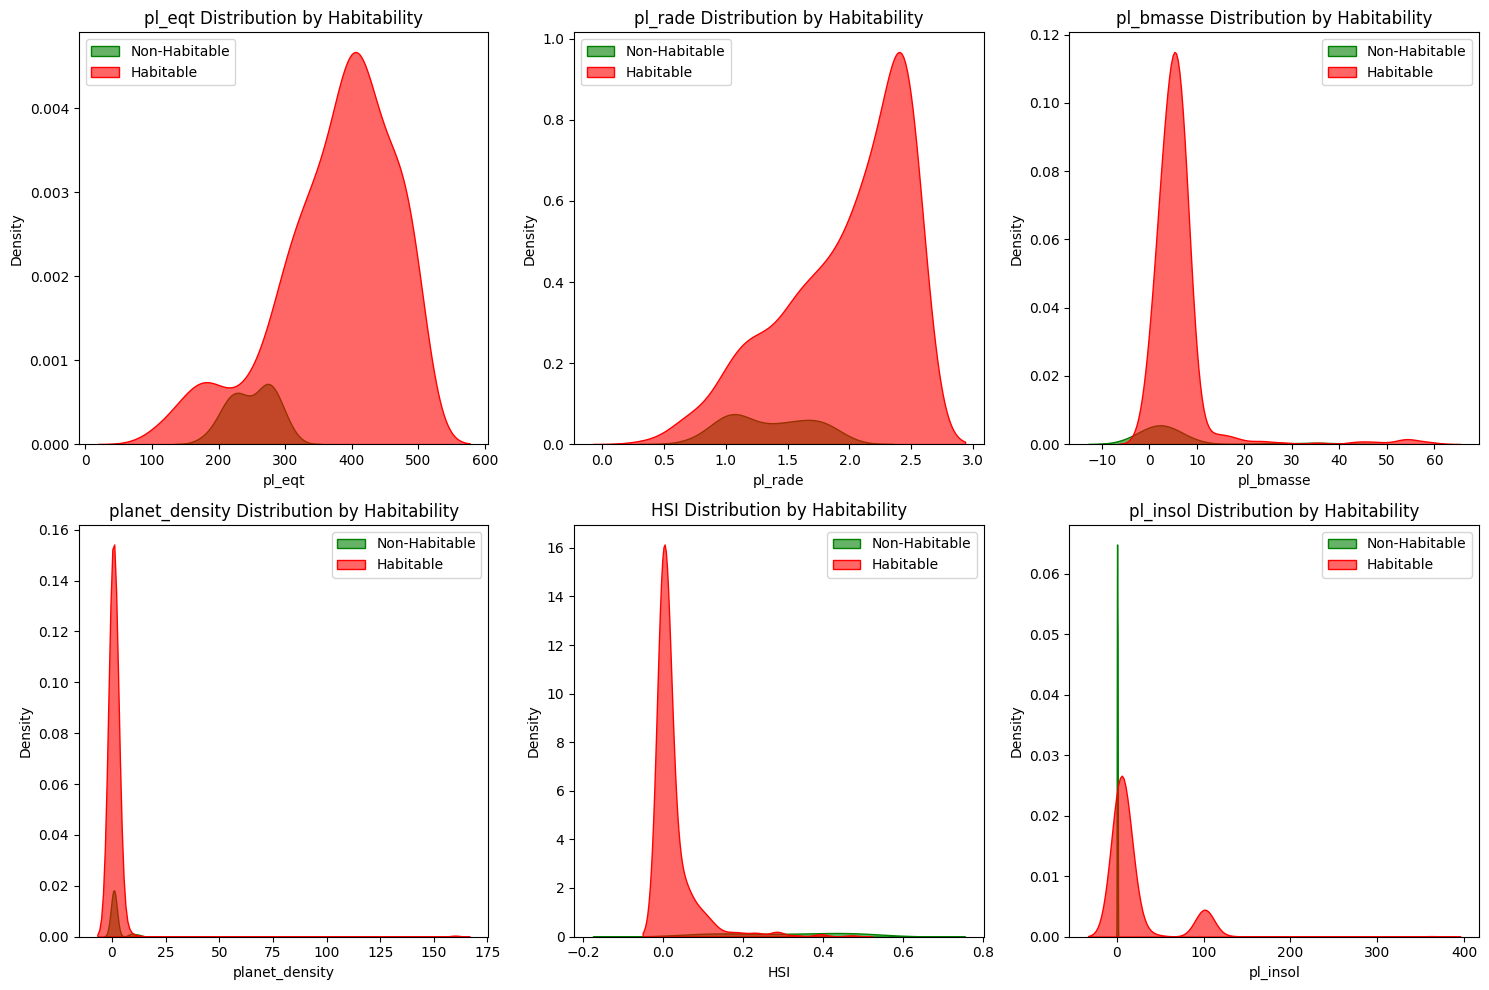

In [11]:
#Feature Distribution by Class (KDE Plots)

print("FEATURE DISTRIBUTIONS BY CLASS")

key_features = ["pl_eqt", "pl_rade", "pl_bmasse", "planet_density", "HSI", "pl_insol"]

n_features = len(key_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for idx, feat in enumerate(key_features):
    if idx < len(axes) and feat in df.columns:
        sns.kdeplot(data=df, x=feat, hue='habitable', fill=True, ax=axes[idx], 
                   palette={0: 'red', 1: 'green'}, alpha=0.6)
        axes[idx].set_title(f'{feat} Distribution by Habitability')
        axes[idx].set_xlabel(feat)
        axes[idx].legend(['Non-Habitable', 'Habitable'])

for idx in range(len(key_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()


DIMENSIONALITY REDUCTION VISUALIZATION

1. Performing PCA...
   Explained Variance: PC1=22.97%, PC2=14.50%
   Total: 37.47%

2. Performing t-SNE (this may take a moment)...
   ✓ t-SNE completed


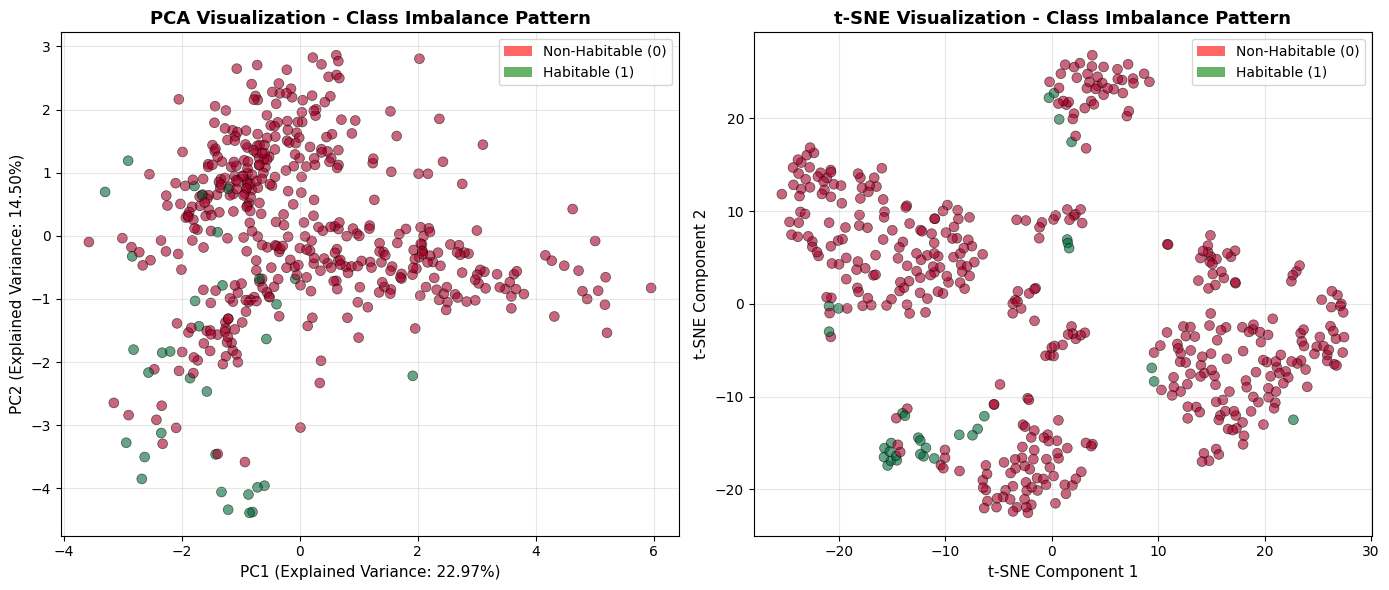


PCA Space - Distance between centroids: 2.690
t-SNE Space - Distance between centroids: 11.201


In [12]:
#Dimensionality Reduction - PCA & t-SNE Visualization
# Purpose: Visualize class imbalance pattern after reducing to 2D
# Color coding: 0 (Non-Habitable) = Red, 1 (Habitable) = Green


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

print("DIMENSIONALITY REDUCTION VISUALIZATION")

# Prepare features (exclude target and name)
feature_cols = [col for col in df.columns if col not in ['pl_name', 'habitable']]
X_viz = df[feature_cols].select_dtypes(include=[np.number])
y_viz = df['habitable']

# Scale data
scaler_viz = StandardScaler()
X_scaled = scaler_viz.fit_transform(X_viz.values)

# PCA
print("\n1. Performing PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
explained_var = pca.explained_variance_ratio_
print(f"   Explained Variance: PC1={explained_var[0]:.2%}, PC2={explained_var[1]:.2%}")
print(f"   Total: {explained_var.sum():.2%}")

# t-SNE
print("\n2. Performing t-SNE (this may take a moment)...")
if X_scaled.shape[0] > 1000:
    print(f"   Using subset of 1000 samples for faster computation...")
    from sklearn.model_selection import train_test_split
    X_tsne_subset, _, y_tsne_subset, _ = train_test_split(
        X_scaled, y_viz, train_size=1000, stratify=y_viz, random_state=42
    )
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    X_tsne = tsne.fit_transform(X_tsne_subset)
    y_tsne = y_tsne_subset.values
else:
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    X_tsne = tsne.fit_transform(X_scaled)
    y_tsne = y_viz.values
print("   ✓ t-SNE completed")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PCA Plot
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_viz.values, 
                          cmap='RdYlGn', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel(f'PC1 (Explained Variance: {explained_var[0]:.2%})', fontsize=11)
axes[0].set_ylabel(f'PC2 (Explained Variance: {explained_var[1]:.2%})', fontsize=11)
axes[0].set_title('PCA Visualization - Class Imbalance Pattern', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', alpha=0.6, label='Non-Habitable (0)'),
                   Patch(facecolor='green', alpha=0.6, label='Habitable (1)')]
axes[0].legend(handles=legend_elements, loc='best')

# t-SNE Plot
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_tsne, 
                          cmap='RdYlGn', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('t-SNE Component 1', fontsize=11)
axes[1].set_ylabel('t-SNE Component 2', fontsize=11)
axes[1].set_title('t-SNE Visualization - Class Imbalance Pattern', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

# Class separation metrics
habitable_pca = X_pca[y_viz.values == 1]
non_habitable_pca = X_pca[y_viz.values == 0]
if len(habitable_pca) > 0 and len(non_habitable_pca) > 0:
    centroid_distance_pca = np.linalg.norm(habitable_pca.mean(axis=0) - non_habitable_pca.mean(axis=0))
    print(f"\nPCA Space - Distance between centroids: {centroid_distance_pca:.3f}")

habitable_tsne = X_tsne[y_tsne == 1]
non_habitable_tsne = X_tsne[y_tsne == 0]
if len(habitable_tsne) > 0 and len(non_habitable_tsne) > 0:
    centroid_distance_tsne = np.linalg.norm(habitable_tsne.mean(axis=0) - non_habitable_tsne.mean(axis=0))
    print(f"t-SNE Space - Distance between centroids: {centroid_distance_tsne:.3f}")


In [13]:
# Import Required Libraries for Modelling

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, precision_recall_curve, 
    auc, confusion_matrix, ConfusionMatrixDisplay, 
    f1_score, matthews_corrcoef
)
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib

print("✓ All libraries imported successfully!")


✓ All libraries imported successfully!


In [14]:
# Prepare Features and Target - BEFORE Train/Test Split


# Define final features
final_features = [
    "pl_rade", "pl_bmasse", "pl_orbper", "pl_eqt", "pl_insol",
    "planet_density", "st_teff", "star_luminosity", "HSI", "SCI",
    "star_type_F", "star_type_G", "star_type_K", "star_type_M"
]

# Ensure all features exist
for f in final_features:
    if f not in df.columns:
        print(f"Warning: Feature '{f}' not found, adding with zeros")
        df[f] = 0

X = df[final_features].copy()
y = df["habitable"].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")


Feature matrix shape: (468, 14)
Target distribution:
habitable
0    435
1     33
Name: count, dtype: int64


In [15]:
# Train/Test Split - IMPORTANT: Split BEFORE any sampling

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,  # Maintain class distribution
    random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining class distribution:\n{y_train.value_counts()}")
print(f"\nTest class distribution:\n{y_test.value_counts()}")


Training set: 374 samples
Test set: 94 samples

Training class distribution:
habitable
0    348
1     26
Name: count, dtype: int64

Test class distribution:
habitable
0    87
1     7
Name: count, dtype: int64


In [16]:
# 6.1: Baseline Logistic Regression

print("BASELINE MODEL 1: LOGISTIC REGRESSION")


lr_baseline = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)

lr_baseline.fit(X_train.values, y_train)
y_pred_lr = lr_baseline.predict(X_test.values)
y_prob_lr = lr_baseline.predict_proba(X_test.values)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))
print(f"\nROC-AUC: {roc_auc_score(y_test, y_prob_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred_lr):.4f}")


BASELINE MODEL 1: LOGISTIC REGRESSION

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        87
           1       0.70      1.00      0.82         7

    accuracy                           0.97        94
   macro avg       0.85      0.98      0.90        94
weighted avg       0.98      0.97      0.97        94


ROC-AUC: 0.9984
F1-Score: 0.8235
Matthews Correlation Coefficient: 0.8221


In [17]:
#Baseline Linear SVM (class-weight balanced)

print("BASELINE MODEL 2: LINEAR SVM (CLASS-WEIGHT BALANCED)")

# Scale features for SVM
scaler_svm = StandardScaler()
X_train_scaled = scaler_svm.fit_transform(X_train.values)
X_test_scaled = scaler_svm.transform(X_test.values)

svm_baseline = SVC(
    kernel='linear',
    class_weight='balanced',
    probability=True,
    random_state=42
)

svm_baseline.fit(X_train_scaled, y_train)
y_pred_svm = svm_baseline.predict(X_test_scaled)
y_prob_svm = svm_baseline.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))
print(f"\nROC-AUC: {roc_auc_score(y_test, y_prob_svm):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_svm):.4f}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred_svm):.4f}")


BASELINE MODEL 2: LINEAR SVM (CLASS-WEIGHT BALANCED)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96        87
           1       0.55      0.86      0.67         7

    accuracy                           0.94        94
   macro avg       0.77      0.90      0.82        94
weighted avg       0.95      0.94      0.94        94


ROC-AUC: 0.9852
F1-Score: 0.6667
Matthews Correlation Coefficient: 0.6531


In [18]:

#Baseline Random Forest (class-weight balanced)

print("BASELINE MODEL 3: RANDOM FOREST (CLASS-WEIGHT BALANCED)")

rf_baseline = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)

rf_baseline.fit(X_train.values, y_train)
y_pred_rf = rf_baseline.predict(X_test.values)
y_prob_rf = rf_baseline.predict_proba(X_test.values)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"\nROC-AUC: {roc_auc_score(y_test, y_prob_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred_rf):.4f}")


BASELINE MODEL 3: RANDOM FOREST (CLASS-WEIGHT BALANCED)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        87
           1       1.00      0.86      0.92         7

    accuracy                           0.99        94
   macro avg       0.99      0.93      0.96        94
weighted avg       0.99      0.99      0.99        94


ROC-AUC: 1.0000
F1-Score: 0.9231
Matthews Correlation Coefficient: 0.9205


BASELINE MODELS SUMMARY

Baseline Models Performance:
              Model  F1-Score  ROC-AUC      MCC
Logistic Regression  0.823529 0.998358 0.822108
       SVM (Linear)  0.666667 0.985222 0.653108
      Random Forest  0.923077 1.000000 0.920545


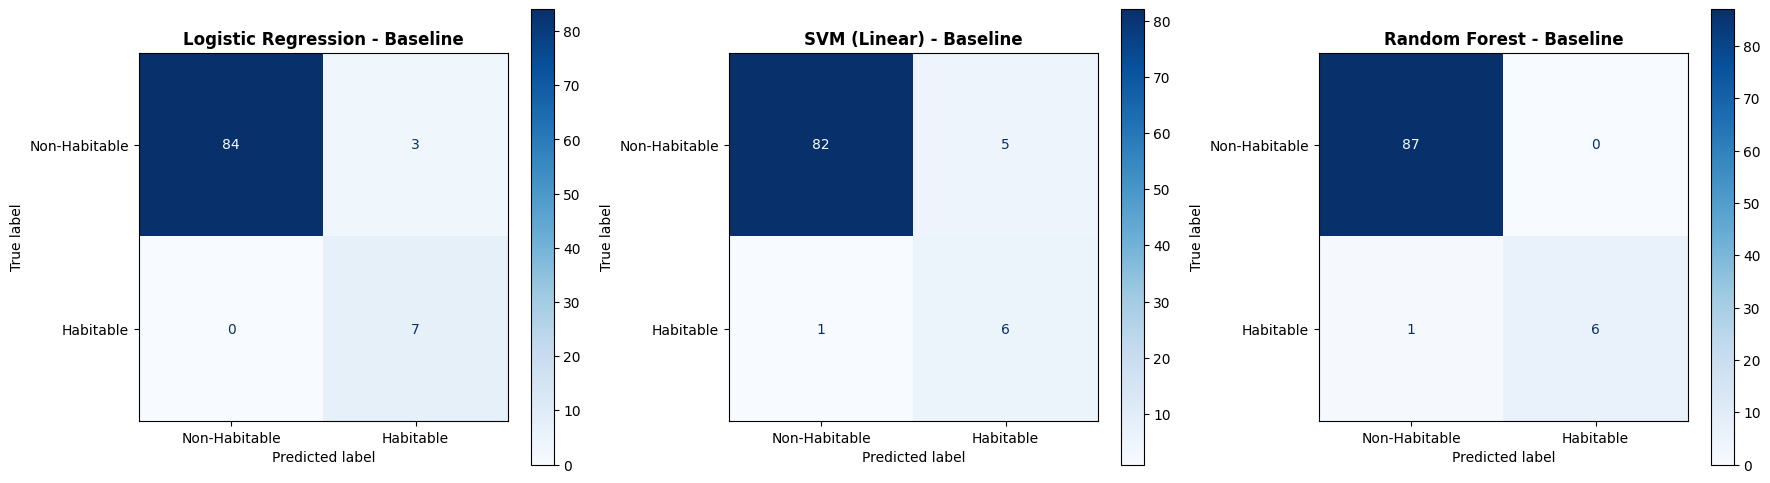

In [19]:

#Baseline Models Comparison

print("BASELINE MODELS SUMMARY")

baseline_models = {
    "Logistic Regression": (lr_baseline, X_test.values, y_prob_lr),
    "SVM (Linear)": (svm_baseline, X_test_scaled, y_prob_svm),
    "Random Forest": (rf_baseline, X_test.values, y_prob_rf)
}

baseline_results = []
for name, (model, X_eval, y_prob) in baseline_models.items():
    y_pred = model.predict(X_eval)
    baseline_results.append({
        'Model': name,
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob),
        'MCC': matthews_corrcoef(y_test, y_pred)
    })

baseline_df = pd.DataFrame(baseline_results)
print("\nBaseline Models Performance:")
print(baseline_df.to_string(index=False))

# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (name, (model, X_eval, _)) in enumerate(baseline_models.items()):
    y_pred = model.predict(X_eval)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Non-Habitable', 'Habitable'])
    disp.plot(ax=axes[idx], cmap='Blues')
    axes[idx].set_title(f'{name} - Baseline', fontweight='bold')

plt.tight_layout()
plt.show()


In [20]:

#SMOTE (Synthetic Minority Oversampling Technique)

print("IMBALANCE HANDLING: SMOTE")

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train.values, y_train)

print(f"Before SMOTE - Training set: {X_train.shape[0]} samples")
print(f"  Class distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"\nAfter SMOTE - Training set: {X_train_smote.shape[0]} samples")
print(f"  Class distribution: {pd.Series(y_train_smote).value_counts().to_dict()}")

# Train Random Forest with SMOTE
rf_smote = RandomForestClassifier(n_estimators=300, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = rf_smote.predict(X_test.values)
y_prob_smote = rf_smote.predict_proba(X_test.values)[:, 1]

print("\nClassification Report (RF + SMOTE):")
print(classification_report(y_test, y_pred_smote))
print(f"\nROC-AUC: {roc_auc_score(y_test, y_prob_smote):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_smote):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred_smote):.4f}")


IMBALANCE HANDLING: SMOTE
Before SMOTE - Training set: 374 samples
  Class distribution: {0: 348, 1: 26}

After SMOTE - Training set: 696 samples
  Class distribution: {0: 348, 1: 348}

Classification Report (RF + SMOTE):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       1.00      1.00      1.00         7

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94


ROC-AUC: 1.0000
F1-Score: 1.0000
MCC: 1.0000


In [21]:
#Borderline-SMOTE


print("="*70)
print("IMBALANCE HANDLING: BORDERLINE-SMOTE")
print("="*70)

borderline_smote = BorderlineSMOTE(random_state=42)
X_train_borderline, y_train_borderline = borderline_smote.fit_resample(X_train.values, y_train)

print(f"After Borderline-SMOTE: {X_train_borderline.shape[0]} samples")

rf_borderline = RandomForestClassifier(n_estimators=300, random_state=42)
rf_borderline.fit(X_train_borderline, y_train_borderline)

y_pred_borderline = rf_borderline.predict(X_test.values)
y_prob_borderline = rf_borderline.predict_proba(X_test.values)[:, 1]

print("\nClassification Report (RF + Borderline-SMOTE):")
print(classification_report(y_test, y_pred_borderline))
print(f"\nROC-AUC: {roc_auc_score(y_test, y_prob_borderline):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_borderline):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred_borderline):.4f}")


IMBALANCE HANDLING: BORDERLINE-SMOTE
After Borderline-SMOTE: 696 samples

Classification Report (RF + Borderline-SMOTE):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       1.00      1.00      1.00         7

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94


ROC-AUC: 1.0000
F1-Score: 1.0000
MCC: 1.0000


In [22]:
#SMOTE + Tomek Links

print("IMBALANCE HANDLING: SMOTE + TOMEK LINKS")

smote_tomek = SMOTETomek(random_state=42)
X_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(X_train.values, y_train)

print(f"After SMOTE+Tomek: {X_train_smote_tomek.shape[0]} samples")

rf_smote_tomek = RandomForestClassifier(n_estimators=300, random_state=42)
rf_smote_tomek.fit(X_train_smote_tomek, y_train_smote_tomek)

y_pred_smote_tomek = rf_smote_tomek.predict(X_test.values)
y_prob_smote_tomek = rf_smote_tomek.predict_proba(X_test.values)[:, 1]

print("\nClassification Report (RF + SMOTE+Tomek):")
print(classification_report(y_test, y_pred_smote_tomek))
print(f"\nROC-AUC: {roc_auc_score(y_test, y_prob_smote_tomek):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_smote_tomek):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred_smote_tomek):.4f}")


IMBALANCE HANDLING: SMOTE + TOMEK LINKS
After SMOTE+Tomek: 682 samples

Classification Report (RF + SMOTE+Tomek):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       1.00      1.00      1.00         7

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94


ROC-AUC: 1.0000
F1-Score: 1.0000
MCC: 1.0000


In [23]:
#ADASYN (Adaptive Synthetic Sampling)

print("IMBALANCE HANDLING: ADASYN")

adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train.values, y_train)

print(f"After ADASYN: {X_train_adasyn.shape[0]} samples")

rf_adasyn = RandomForestClassifier(n_estimators=300, random_state=42)
rf_adasyn.fit(X_train_adasyn, y_train_adasyn)

y_pred_adasyn = rf_adasyn.predict(X_test.values)
y_prob_adasyn = rf_adasyn.predict_proba(X_test.values)[:, 1]

print("\nClassification Report (RF + ADASYN):")
print(classification_report(y_test, y_pred_adasyn))
print(f"\nROC-AUC: {roc_auc_score(y_test, y_prob_adasyn):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_adasyn):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred_adasyn):.4f}")


IMBALANCE HANDLING: ADASYN
After ADASYN: 693 samples

Classification Report (RF + ADASYN):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       1.00      1.00      1.00         7

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94


ROC-AUC: 1.0000
F1-Score: 1.0000
MCC: 1.0000


In [24]:
#Model-Level Techniques - XGBoost with scale_pos_weight

print("MODEL-LEVEL TECHNIQUE: XGBOOST (scale_pos_weight)")

pos_weight = (y_train == 0).sum() / max(1, (y_train == 1).sum())
print(f"Positive class weight: {pos_weight:.2f}")

xgb = XGBClassifier(
    scale_pos_weight=pos_weight,
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

xgb.fit(X_train.values, y_train)
y_pred_xgb = xgb.predict(X_test.values)
y_prob_xgb = xgb.predict_proba(X_test.values)[:, 1]

print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))
print(f"\nROC-AUC: {roc_auc_score(y_test, y_prob_xgb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred_xgb):.4f}")


MODEL-LEVEL TECHNIQUE: XGBOOST (scale_pos_weight)
Positive class weight: 13.38

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       1.00      1.00      1.00         7

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94


ROC-AUC: 1.0000
F1-Score: 1.0000
MCC: 1.0000


In [25]:
#Comparison of All Imbalance Handling Techniques

print("IMBALANCE HANDLING TECHNIQUES COMPARISON")

sampling_results = {
    "Baseline RF": (rf_baseline, X_test.values),
    "SMOTE": (rf_smote, X_test.values),
    "Borderline-SMOTE": (rf_borderline, X_test.values),
    "SMOTE+Tomek": (rf_smote_tomek, X_test.values),
    "ADASYN": (rf_adasyn, X_test.values),
    "XGBoost (scale_pos_weight)": (xgb, X_test.values)
}

comparison_results = []
for name, (model, X_eval) in sampling_results.items():
    y_pred = model.predict(X_eval)
    y_prob = model.predict_proba(X_eval)[:, 1]
    comparison_results.append({
        'Technique': name,
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob),
        'MCC': matthews_corrcoef(y_test, y_pred)
    })

comparison_df = pd.DataFrame(comparison_results).sort_values('F1-Score', ascending=False)
print("\nPerformance Comparison:")
print(comparison_df.to_string(index=False))


IMBALANCE HANDLING TECHNIQUES COMPARISON

Performance Comparison:
                 Technique  F1-Score  ROC-AUC      MCC
                     SMOTE  1.000000      1.0 1.000000
          Borderline-SMOTE  1.000000      1.0 1.000000
                    ADASYN  1.000000      1.0 1.000000
               SMOTE+Tomek  1.000000      1.0 1.000000
XGBoost (scale_pos_weight)  1.000000      1.0 1.000000
               Baseline RF  0.923077      1.0 0.920545


In [26]:
#Build Full Pipeline (Scaler + SMOTE + Random Forest)

print("FULL PIPELINE: Scaler + SMOTE + Random Forest")

pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(n_estimators=300, random_state=42))
])

# Train pipeline
pipeline.fit(X_train.values, y_train)

# Evaluate
y_pred_pipe = pipeline.predict(X_test.values)
y_prob_pipe = pipeline.predict_proba(X_test.values)[:, 1]

print("\nClassification Report (Pipeline):")
print(classification_report(y_test, y_pred_pipe))
print(f"\nROC-AUC: {roc_auc_score(y_test, y_prob_pipe):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_pipe):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred_pipe):.4f}")


FULL PIPELINE: Scaler + SMOTE + Random Forest

Classification Report (Pipeline):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       1.00      1.00      1.00         7

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94


ROC-AUC: 1.0000
F1-Score: 1.0000
MCC: 1.0000


In [27]:
#Cross-Validation with Pipeline (Stratified K-Fold)

print("CROSS-VALIDATION (5-Fold Stratified K-Fold)")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores_roc = cross_val_score(
    pipeline, 
    X_train.values, 
    y_train, 
    cv=cv, 
    scoring="roc_auc"
)

cv_scores_f1 = cross_val_score(
    pipeline,
    X_train.values,
    y_train,
    cv=cv,
    scoring="f1"
)

print(f"\nROC-AUC Scores: {cv_scores_roc}")
print(f"Mean ROC-AUC: {cv_scores_roc.mean():.4f} (+/- {cv_scores_roc.std() * 2:.4f})")

print(f"\nF1-Score: {cv_scores_f1}")
print(f"Mean F1-Score: {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")


CROSS-VALIDATION (5-Fold Stratified K-Fold)

ROC-AUC Scores: [1.         1.         0.98857143 0.99758454 1.        ]
Mean ROC-AUC: 0.9972 (+/- 0.0089)

F1-Score: [1.         0.83333333 0.90909091 0.8        0.83333333]
Mean F1-Score: 0.8752 (+/- 0.1439)


PRECISION-RECALL CURVES


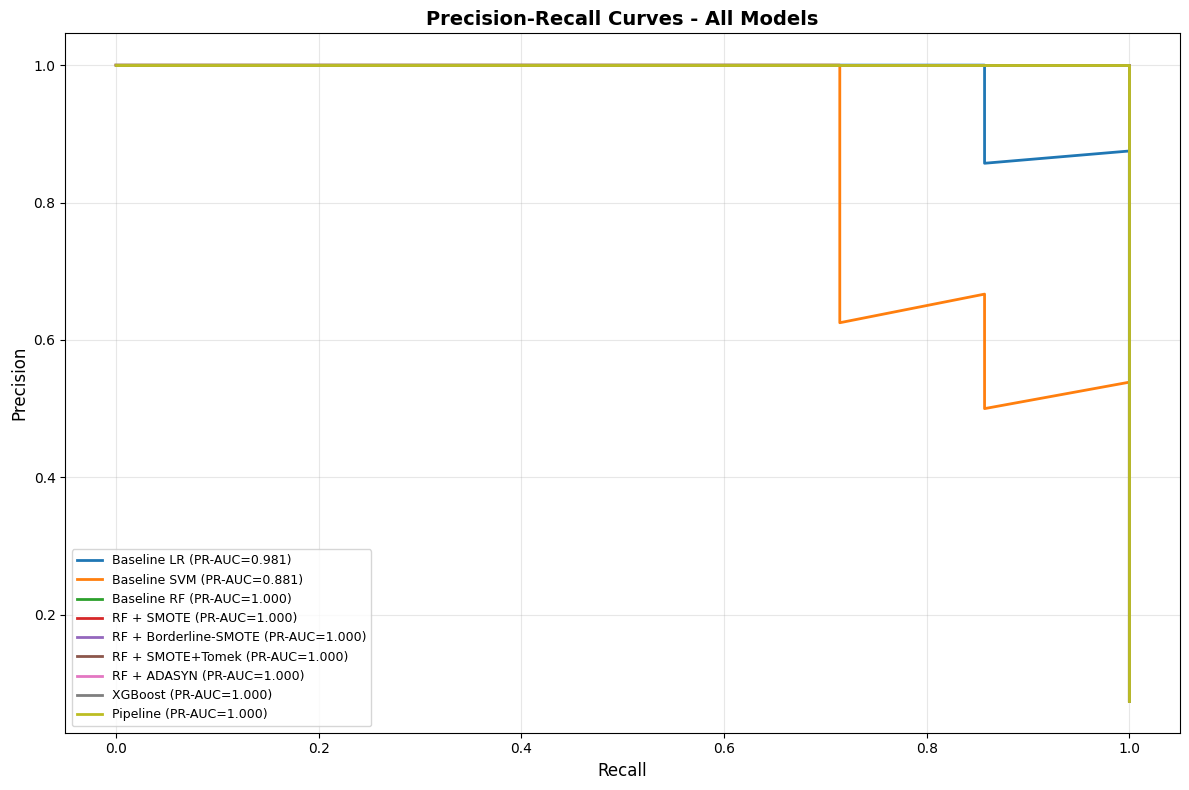

In [28]:
#Precision-Recall Curves for All Models

print("PRECISION-RECALL CURVES")

all_models = {
    "Baseline LR": (lr_baseline, X_test.values, y_prob_lr),
    "Baseline SVM": (svm_baseline, X_test_scaled, y_prob_svm),
    "Baseline RF": (rf_baseline, X_test.values, y_prob_rf),
    "RF + SMOTE": (rf_smote, X_test.values, y_prob_smote),
    "RF + Borderline-SMOTE": (rf_borderline, X_test.values, y_prob_borderline),
    "RF + SMOTE+Tomek": (rf_smote_tomek, X_test.values, y_prob_smote_tomek),
    "RF + ADASYN": (rf_adasyn, X_test.values, y_prob_adasyn),
    "XGBoost": (xgb, X_test.values, y_prob_xgb),
    "Pipeline": (pipeline, X_test.values, y_prob_pipe)
}

plt.figure(figsize=(12, 8))

for name, (model, X_eval, y_prob) in all_models.items():
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (PR-AUC={pr_auc:.3f})", linewidth=2)

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curves - All Models", fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


CONFUSION MATRICES


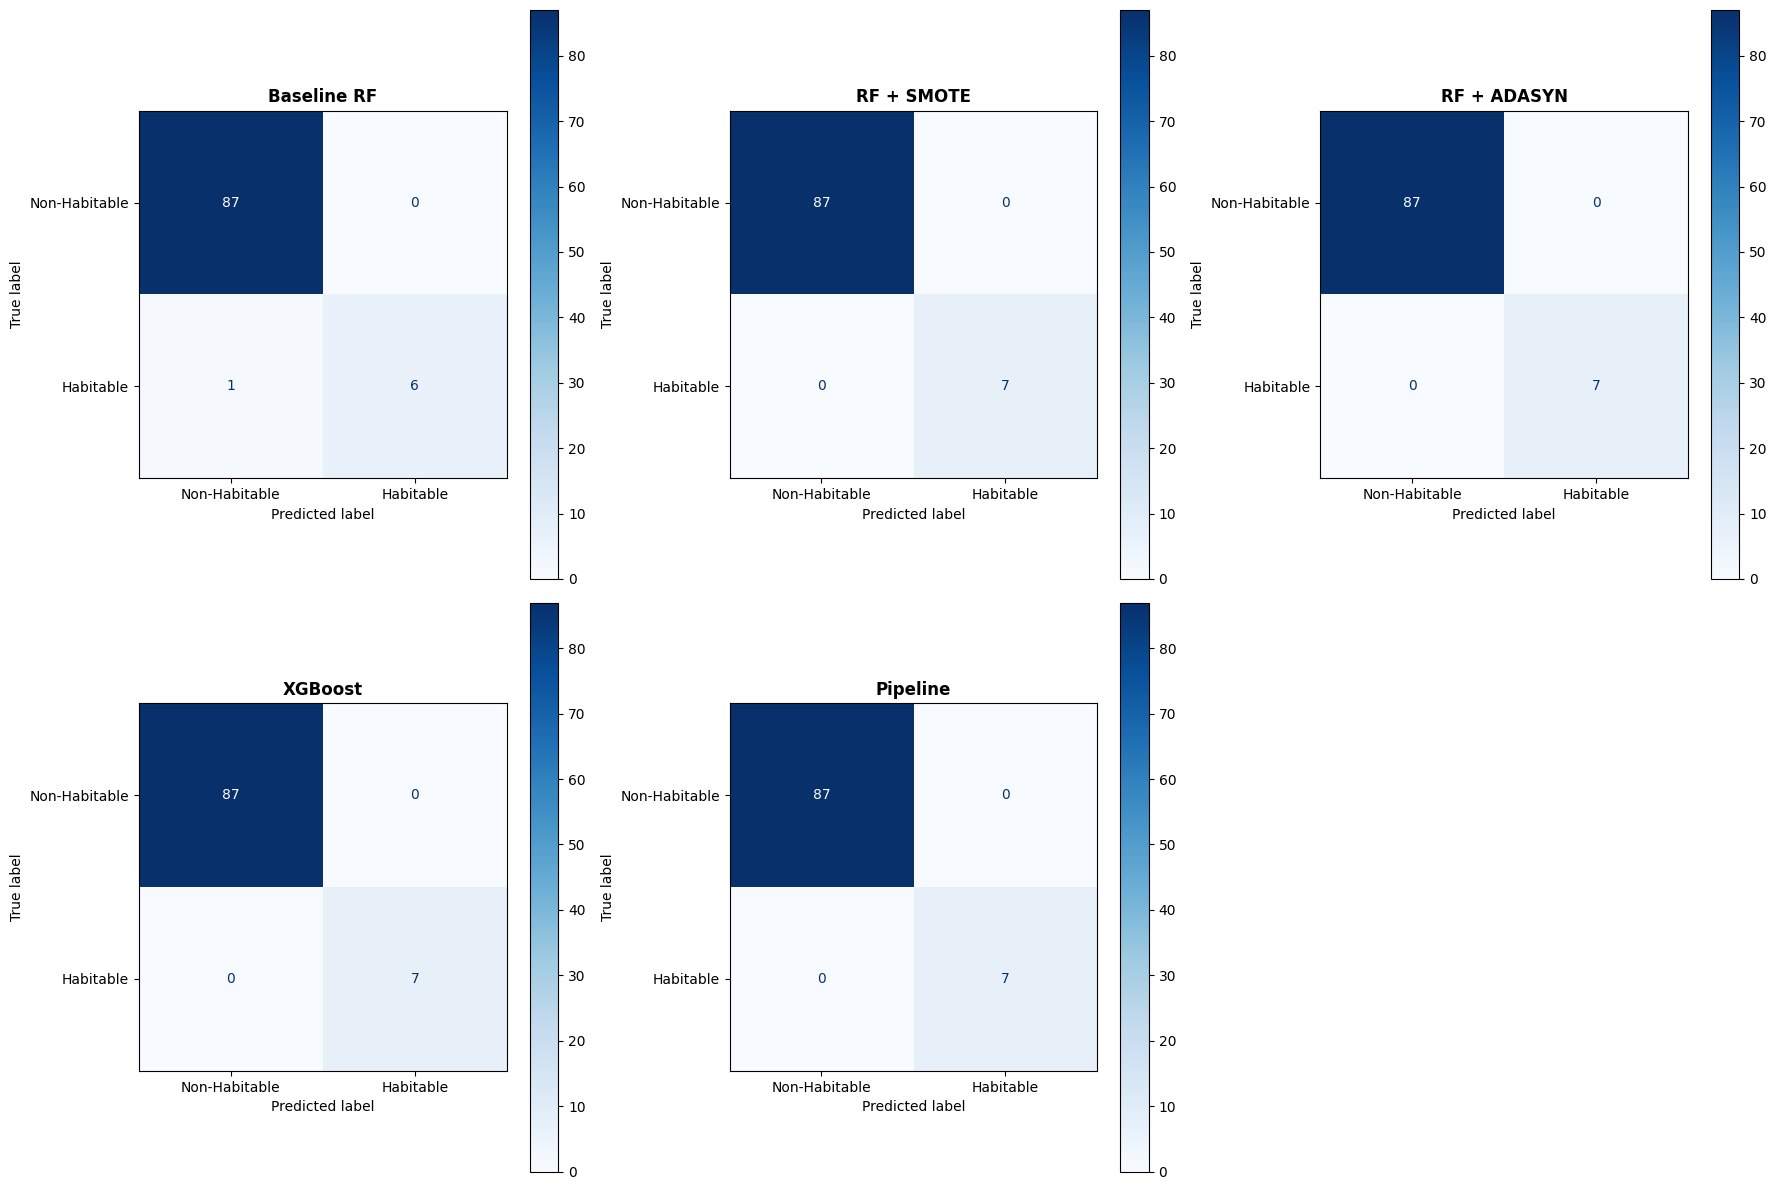

In [29]:

#Confusion Matrices - Baseline vs Sampled Models

print("CONFUSION MATRICES")

# Select key models for visualization
key_models = {
    "Baseline RF": (rf_baseline, X_test.values),
    "RF + SMOTE": (rf_smote, X_test.values),
    "RF + ADASYN": (rf_adasyn, X_test.values),
    "XGBoost": (xgb, X_test.values),
    "Pipeline": (pipeline, X_test.values)
}

n_models = len(key_models)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for idx, (name, (model, X_eval)) in enumerate(key_models.items()):
    y_pred = model.predict(X_eval)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Non-Habitable', 'Habitable'])
    disp.plot(ax=axes[idx], cmap='Blues')
    axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')

# Hide extra subplots
for idx in range(n_models, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()


In [30]:
#Hyperparameter Tuning - XGBoost

print("HYPERPARAMETER TUNING: XGBOOST")

from sklearn.model_selection import GridSearchCV

# Define parameter grid
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'scale_pos_weight': [pos_weight, pos_weight * 1.5]
}

# Create XGBoost with pipeline
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42))
])

# Grid search with stratified CV
print("Performing grid search (this may take a moment)...")
xgb_grid = GridSearchCV(
    xgb_pipeline,
    param_grid={'model__' + k: v for k, v in xgb_param_grid.items()},
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train.values, y_train)

print(f"\nBest parameters: {xgb_grid.best_params_}")
print(f"Best CV F1-Score: {xgb_grid.best_score_:.4f}")

# Evaluate best model
y_pred_xgb_tuned = xgb_grid.predict(X_test.values)
y_prob_xgb_tuned = xgb_grid.predict_proba(X_test.values)[:, 1]

print("\nClassification Report (Tuned XGBoost):")
print(classification_report(y_test, y_pred_xgb_tuned))
print(f"\nF1-Score: {f1_score(y_test, y_pred_xgb_tuned):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_xgb_tuned):.4f}")


HYPERPARAMETER TUNING: XGBOOST
Performing grid search (this may take a moment)...
Fitting 3 folds for each of 18 candidates, totalling 54 fits

Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__scale_pos_weight': np.float64(13.384615384615385)}
Best CV F1-Score: 0.9213

Classification Report (Tuned XGBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       1.00      1.00      1.00         7

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94


F1-Score: 1.0000
ROC-AUC: 1.0000


INTERPRETABILITY: LOGISTIC REGRESSION COEFFICIENTS

Top 10 Most Important Features (by absolute coefficient):
        Feature  Coefficient  Abs_Coefficient
       pl_insol    -2.508191         2.508191
        pl_rade    -1.816333         1.816333
            HSI     1.114382         1.114382
 planet_density     0.919925         0.919925
    star_type_K     0.815022         0.815022
    star_type_G    -0.680067         0.680067
    star_type_M     0.458942         0.458942
      pl_bmasse    -0.179301         0.179301
            SCI     0.064281         0.064281
star_luminosity     0.036407         0.036407


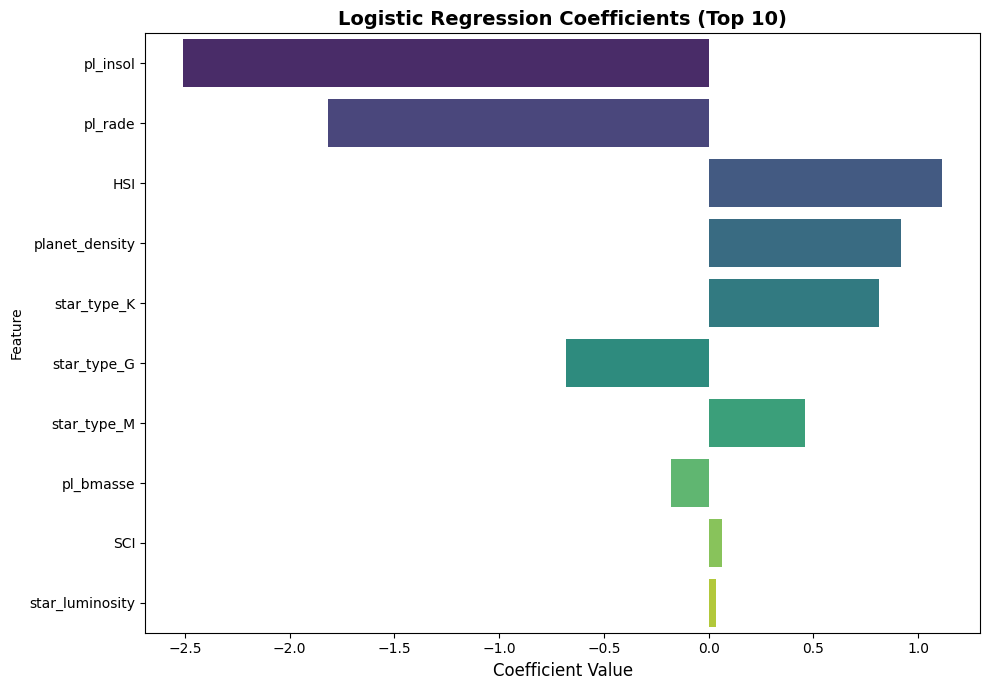

In [31]:
#Logistic Regression Coefficients

print("INTERPRETABILITY: LOGISTIC REGRESSION COEFFICIENTS")

lr_coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_baseline.coef_[0],
    'Abs_Coefficient': np.abs(lr_baseline.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 10 Most Important Features (by absolute coefficient):")
print(lr_coef_df.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 7))
sns.barplot(x='Coefficient', y='Feature', data=lr_coef_df.head(10), palette='viridis')
plt.title('Logistic Regression Coefficients (Top 10)', fontsize=14, fontweight='bold')
plt.xlabel('Coefficient Value', fontsize=12)
plt.tight_layout()
plt.show()


INTERPRETABILITY: RANDOM FOREST FEATURE IMPORTANCE

Top 10 Most Important Features:
        Feature  Importance
       pl_insol    0.290175
         pl_eqt    0.216136
            HSI    0.211198
        pl_rade    0.117451
 planet_density    0.079126
      pl_bmasse    0.041874
            SCI    0.011915
        st_teff    0.009577
star_luminosity    0.009483
      pl_orbper    0.009235


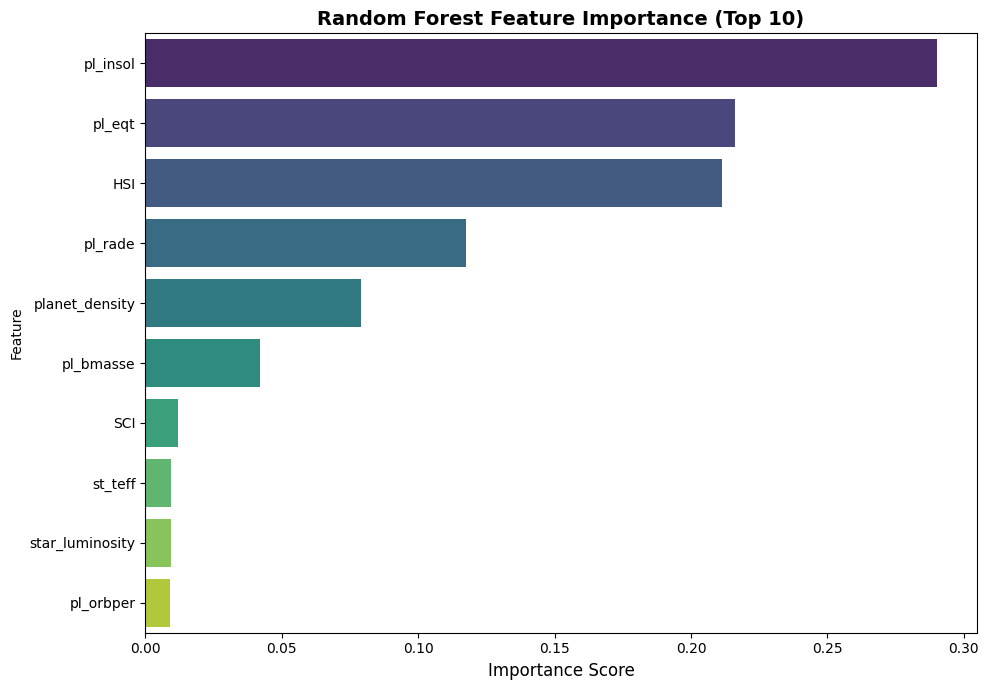

In [32]:
#Random Forest Feature Importance

print("INTERPRETABILITY: RANDOM FOREST FEATURE IMPORTANCE")

rf_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_smote.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(rf_importance_df.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df.head(10), palette='viridis')
plt.title('Random Forest Feature Importance (Top 10)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.tight_layout()
plt.show()


INTERPRETABILITY: XGBOOST FEATURE IMPORTANCE

Top 10 Most Important Features:
        Feature  Importance
       pl_insol    0.754418
        pl_rade    0.178658
        st_teff    0.020441
         pl_eqt    0.019457
            HSI    0.008022
      pl_orbper    0.007822
      pl_bmasse    0.004841
            SCI    0.002757
 planet_density    0.002038
star_luminosity    0.001546


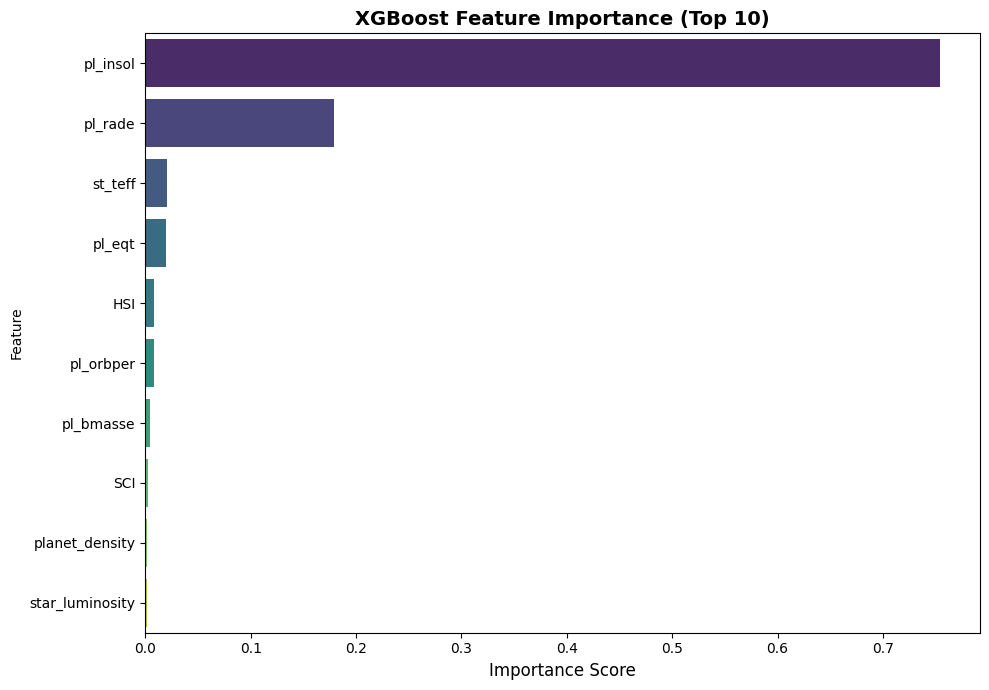

In [33]:
#XGBoost Feature Importance

print("INTERPRETABILITY: XGBOOST FEATURE IMPORTANCE")

xgb_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(xgb_importance_df.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=xgb_importance_df.head(10), palette='viridis')
plt.title('XGBoost Feature Importance (Top 10)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.tight_layout()
plt.show()


INTERPRETABILITY: PERMUTATION IMPORTANCE

Top 10 Most Important Features (Permutation Importance):
        Feature  Importance_Mean  Importance_Std
       pl_insol         0.650000        0.213784
            HSI         0.139744        0.041126
        pl_rade         0.115385        0.067353
         pl_eqt         0.046154        0.037684
      pl_orbper         0.000000        0.000000
      pl_bmasse         0.000000        0.000000
 planet_density         0.000000        0.000000
        st_teff         0.000000        0.000000
star_luminosity         0.000000        0.000000
            SCI         0.000000        0.000000


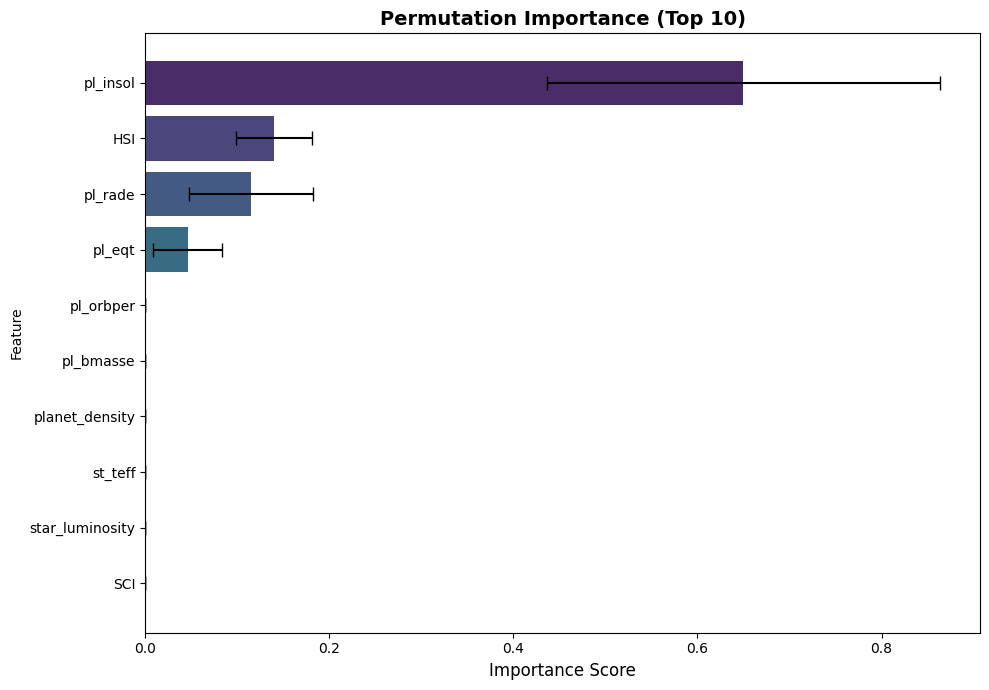

In [34]:
#Permutation Importance

print("INTERPRETABILITY: PERMUTATION IMPORTANCE")

from sklearn.inspection import permutation_importance

# Use the best model (pipeline)
perm_result = permutation_importance(
    pipeline,
    X_test.values,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='f1',
    n_jobs=-1
)

perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance_Mean': perm_result.importances_mean,
    'Importance_Std': perm_result.importances_std
}).sort_values('Importance_Mean', ascending=False)

print("\nTop 10 Most Important Features (Permutation Importance):")
print(perm_importance_df.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance_Mean', y='Feature', data=perm_importance_df.head(10), palette='viridis')
plt.errorbar(perm_importance_df.head(10)['Importance_Mean'], 
             range(len(perm_importance_df.head(10))),
             xerr=perm_importance_df.head(10)['Importance_Std'],
             fmt='none', color='black', capsize=5)
plt.title('Permutation Importance (Top 10)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.tight_layout()
plt.show()


In [35]:
#SHAP Values (Best Interpretability Layer)

print("="*70)
print("INTERPRETABILITY: SHAP VALUES")
print("="*70)

try:
    import shap
    
    # Use a subset for faster computation
    X_test_shap = X_test.values[:50]  # Use first 50 samples
    
    # Create SHAP explainer for Random Forest
    explainer = shap.TreeExplainer(rf_smote)
    shap_values = explainer.shap_values(X_test_shap)
    
    # For binary classification, use positive class
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Use positive class
    
    # Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_shap, feature_names=X.columns, show=False)
    plt.title('SHAP Summary Plot - Feature Importance', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Feature importance from SHAP
    shap_importance = np.abs(shap_values).mean(0)
    shap_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'SHAP_Importance': shap_importance
    }).sort_values('SHAP_Importance', ascending=False)
    
    print("\nTop 10 Most Important Features (SHAP):")
    print(shap_importance_df.head(10).to_string(index=False))
    
except ImportError:
    print("SHAP library not installed. Install with: pip install shap")
    print("Skipping SHAP analysis...")
except Exception as e:
    print(f"Error in SHAP analysis: {e}")
    print("Continuing without SHAP...")


INTERPRETABILITY: SHAP VALUES
SHAP library not installed. Install with: pip install shap
Skipping SHAP analysis...


COMBINED FEATURE IMPORTANCE RANKING
✓ Added Logistic Regression coefficients
✓ Added Random Forest importance
✓ Added XGBoost importance
✓ Added Permutation importance

✓ Combined 4 importance metrics

Top 15 Most Important Features (Combined Ranking):
        Feature  Average_Importance
       pl_insol            1.000000
        pl_rade            0.385812
            HSI            0.349438
         pl_eqt            0.211575
 planet_density            0.160538
    star_type_K            0.083245
    star_type_G            0.068443
      pl_bmasse            0.055552
    star_type_M            0.046376
            SCI            0.017587
        st_teff            0.015071
star_luminosity            0.012311
      pl_orbper            0.011603
    star_type_F            0.000000


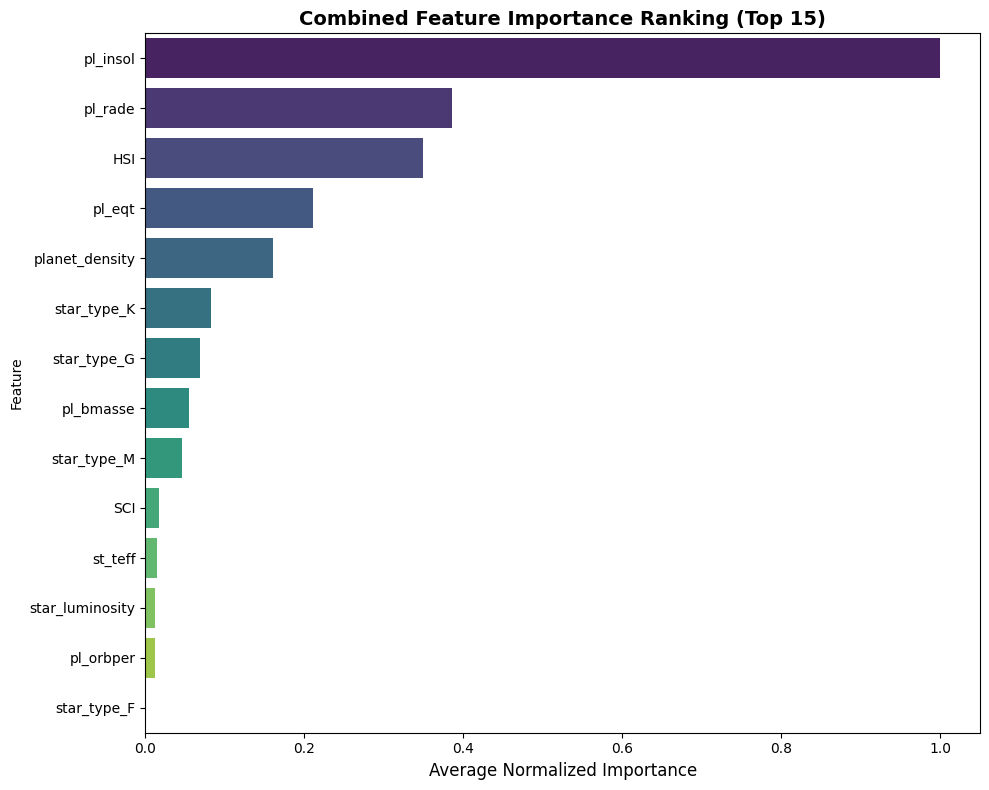

In [36]:
#Combined Feature Importance Ranking

print("COMBINED FEATURE IMPORTANCE RANKING")

# Normalize and combine importance scores
combined_importance = pd.DataFrame({'Feature': X.columns})
importance_cols = []

# Normalize each importance to 0-1 scale and align with X.columns order
# Use dictionary mapping to ensure proper alignment

# Logistic Regression coefficients
try:
    lr_coef_dict = dict(zip(lr_coef_df['Feature'], np.abs(lr_coef_df['Coefficient'])))
    lr_max = max(lr_coef_dict.values()) if lr_coef_dict and max(lr_coef_dict.values()) > 0 else 1
    combined_importance['LR_Coeff'] = combined_importance['Feature'].map(lr_coef_dict).fillna(0) / lr_max
    importance_cols.append('LR_Coeff')
    print("✓ Added Logistic Regression coefficients")
except Exception as e:
    print(f"Warning: Could not add LR coefficients: {e}")

# Random Forest importance
try:
    rf_imp_dict = dict(zip(rf_importance_df['Feature'], rf_importance_df['Importance']))
    rf_max = max(rf_imp_dict.values()) if rf_imp_dict and max(rf_imp_dict.values()) > 0 else 1
    combined_importance['RF_Importance'] = combined_importance['Feature'].map(rf_imp_dict).fillna(0) / rf_max
    importance_cols.append('RF_Importance')
    print("✓ Added Random Forest importance")
except Exception as e:
    print(f"Warning: Could not add RF importance: {e}")

# XGBoost importance
try:
    xgb_imp_dict = dict(zip(xgb_importance_df['Feature'], xgb_importance_df['Importance']))
    xgb_max = max(xgb_imp_dict.values()) if xgb_imp_dict and max(xgb_imp_dict.values()) > 0 else 1
    combined_importance['XGB_Importance'] = combined_importance['Feature'].map(xgb_imp_dict).fillna(0) / xgb_max
    importance_cols.append('XGB_Importance')
    print("✓ Added XGBoost importance")
except Exception as e:
    print(f"Warning: Could not add XGB importance: {e}")

# Permutation importance
try:
    perm_imp_dict = dict(zip(perm_importance_df['Feature'], perm_importance_df['Importance_Mean']))
    perm_max = max(perm_imp_dict.values()) if perm_imp_dict and max(perm_imp_dict.values()) > 0 else 1
    combined_importance['Perm_Importance'] = combined_importance['Feature'].map(perm_imp_dict).fillna(0) / perm_max
    importance_cols.append('Perm_Importance')
    print("✓ Added Permutation importance")
except Exception as e:
    print(f"Warning: Could not add Permutation importance: {e}")

# Average importance (only use columns that were successfully added)
if len(importance_cols) > 0:
    combined_importance['Average_Importance'] = combined_importance[importance_cols].mean(axis=1)
    combined_importance = combined_importance.sort_values('Average_Importance', ascending=False)
    
    print(f"\n✓ Combined {len(importance_cols)} importance metrics")
    print("\nTop 15 Most Important Features (Combined Ranking):")
    print(combined_importance.head(15)[['Feature', 'Average_Importance']].to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Average_Importance', y='Feature', data=combined_importance.head(15), palette='viridis')
    plt.title('Combined Feature Importance Ranking (Top 15)', fontsize=14, fontweight='bold')
    plt.xlabel('Average Normalized Importance', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠ Warning: No importance metrics available. Using Random Forest importance only.")
    combined_importance['Average_Importance'] = combined_importance.get('RF_Importance', 0)
    combined_importance = combined_importance.sort_values('Average_Importance', ascending=False)


BI-VARIATE ANALYSIS: TOP FEATURES BY CLASS

Analyzing top 5 features: ['pl_insol', 'pl_rade', 'HSI', 'pl_eqt', 'planet_density']


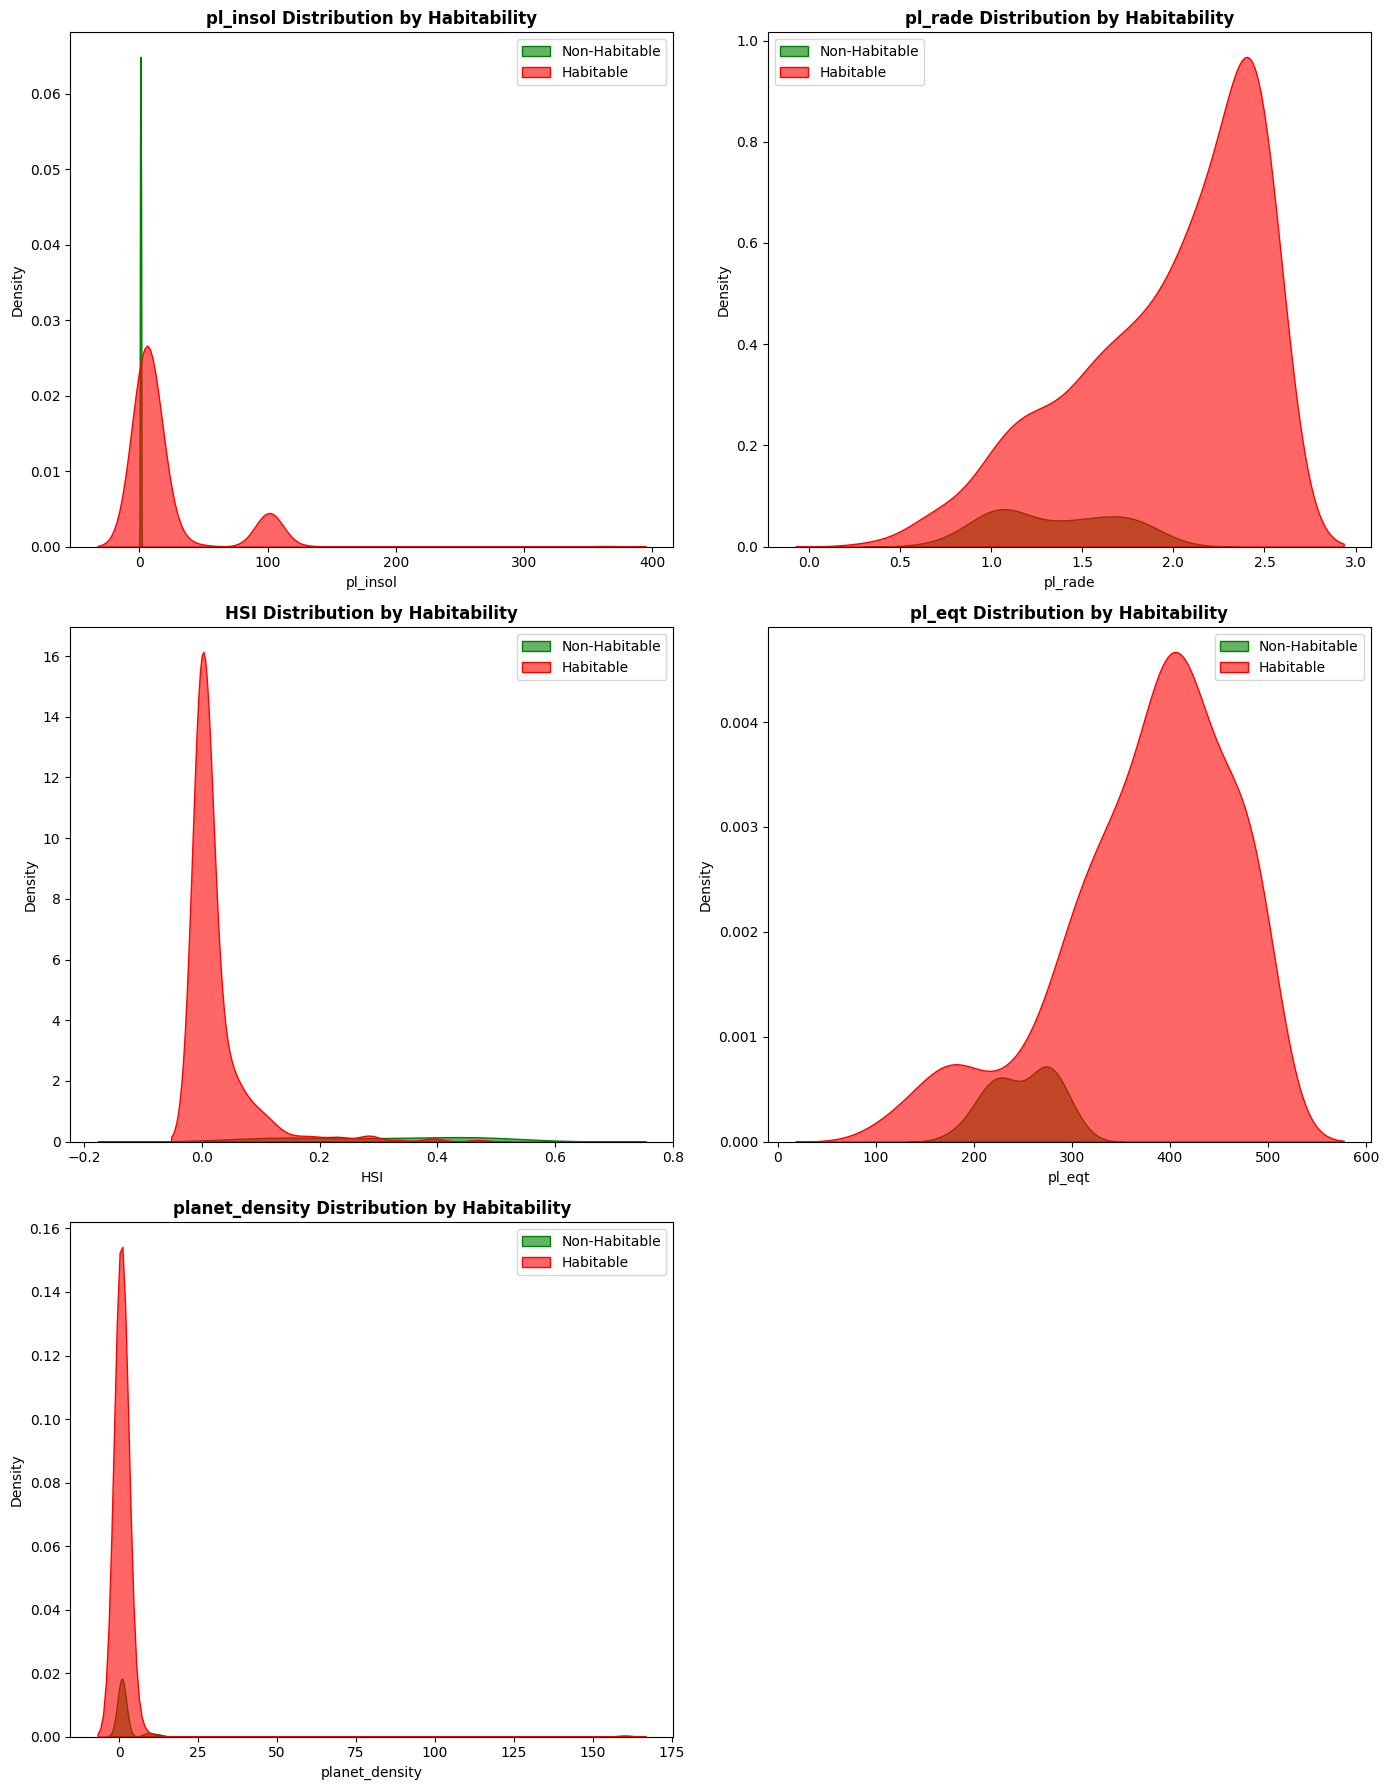

In [37]:
#Bi-Variate Analysis - Top Features Distribution by Class

print("BI-VARIATE ANALYSIS: TOP FEATURES BY CLASS")

top_features = combined_importance.head(5)['Feature'].tolist()
print(f"\nAnalyzing top 5 features: {top_features}")

n_features = len(top_features)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for idx, feat in enumerate(top_features):
    if idx < len(axes) and feat in df.columns:
        sns.kdeplot(data=df, x=feat, hue='habitable', fill=True, ax=axes[idx],
                   palette={0: 'red', 1: 'green'}, alpha=0.6)
        axes[idx].set_title(f'{feat} Distribution by Habitability', fontweight='bold')
        axes[idx].set_xlabel(feat)
        axes[idx].legend(['Non-Habitable', 'Habitable'])

for idx in range(len(top_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()


SCATTER MATRIX: TOP 3 IMPORTANT FEATURES

Top 3 features: ['pl_insol', 'pl_rade', 'HSI']


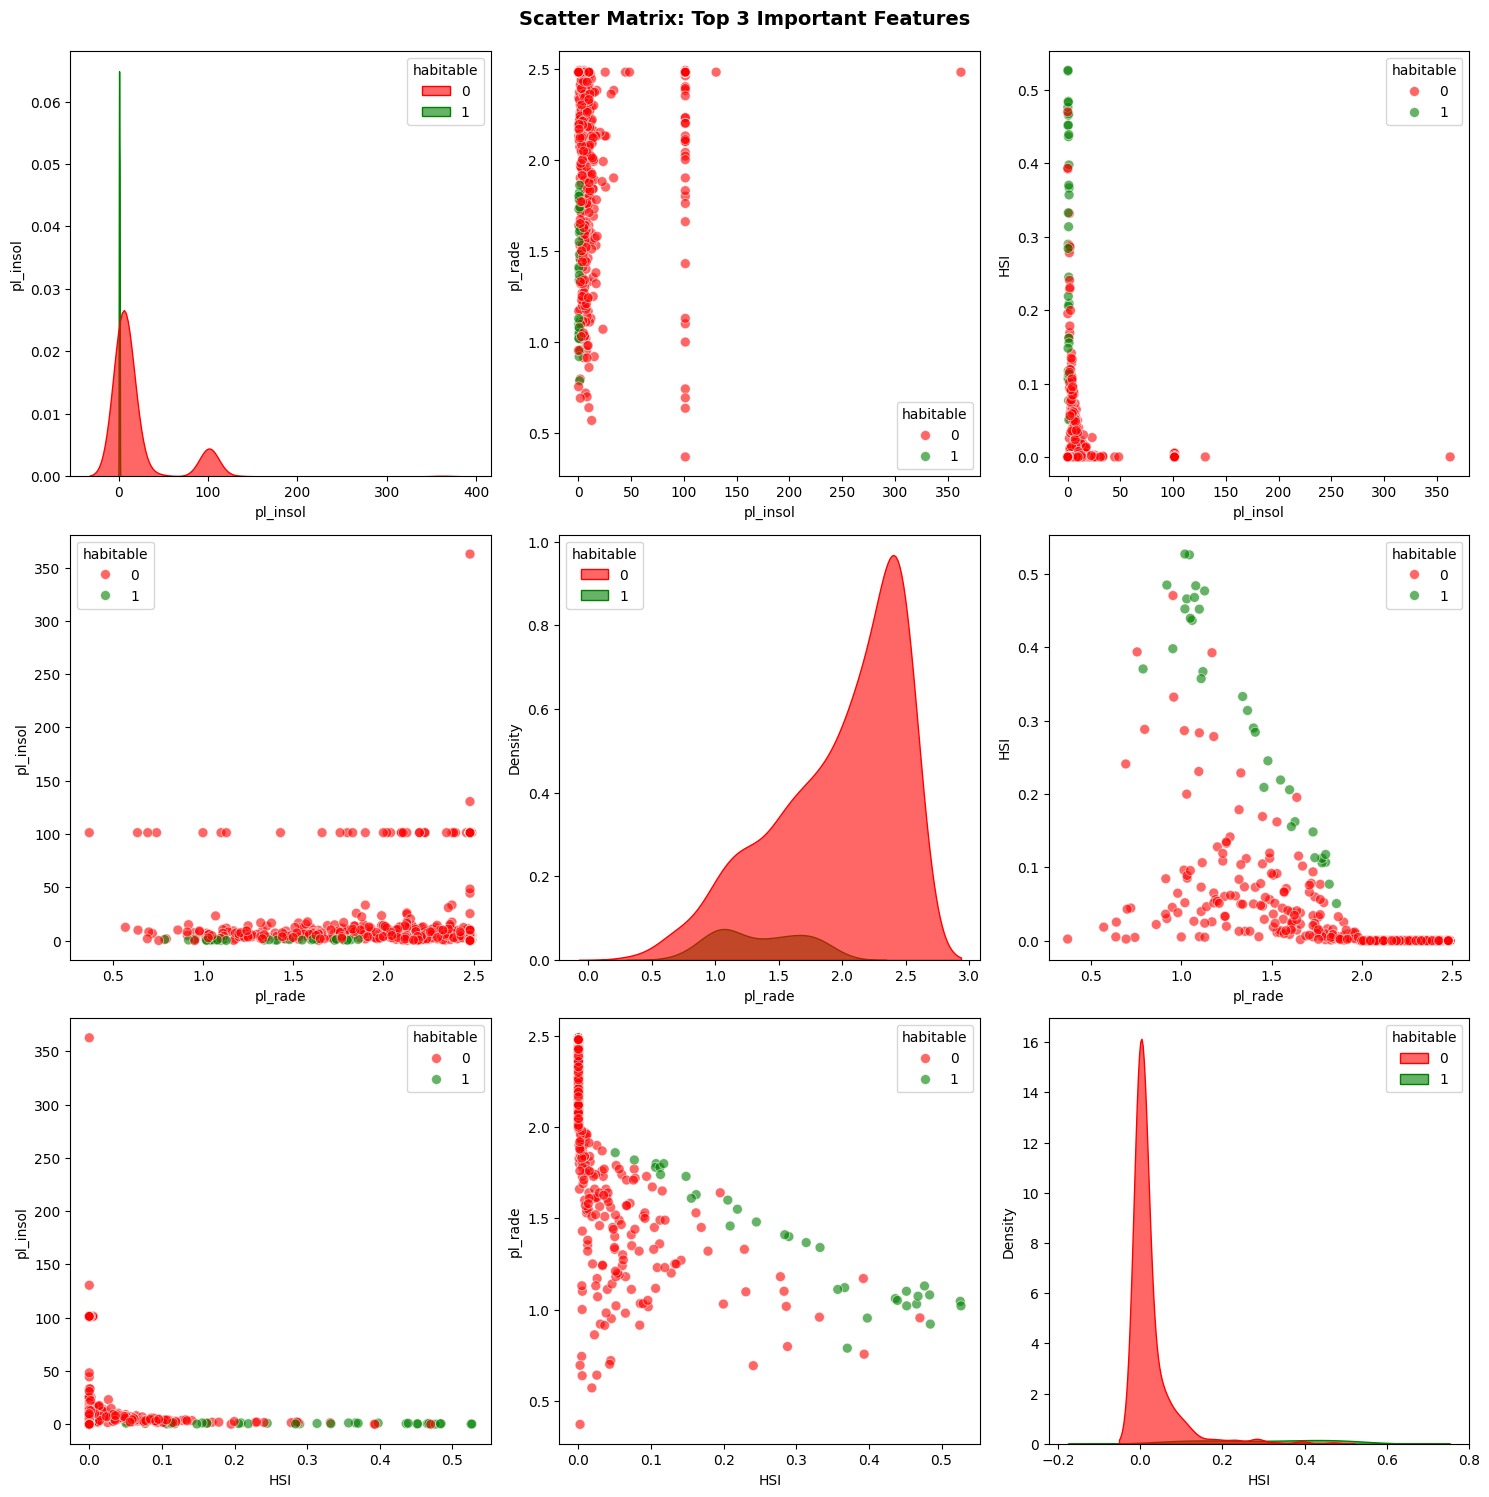

In [38]:
#Scatter Matrix for Top 3 Important Features

print("SCATTER MATRIX: TOP 3 IMPORTANT FEATURES")

top_3_features = combined_importance.head(3)['Feature'].tolist()
print(f"\nTop 3 features: {top_3_features}")

# Create scatter matrix
scatter_data = df[top_3_features + ['habitable']].copy()

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, feat1 in enumerate(top_3_features):
    for j, feat2 in enumerate(top_3_features):
        if i == j:
            # Diagonal: KDE plot
            sns.kdeplot(data=scatter_data, x=feat1, hue='habitable', 
                       ax=axes[i, j], palette={0: 'red', 1: 'green'}, fill=True, alpha=0.6)
        else:
            # Off-diagonal: Scatter plot
            sns.scatterplot(data=scatter_data, x=feat1, y=feat2, hue='habitable',
                          ax=axes[i, j], palette={0: 'red', 1: 'green'}, alpha=0.6, s=50)
        
        if i == len(top_3_features) - 1:
            axes[i, j].set_xlabel(feat1, fontsize=10)
        if j == 0:
            axes[i, j].set_ylabel(feat2, fontsize=10)

plt.suptitle('Scatter Matrix: Top 3 Important Features', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


In [39]:
#Select Best Model and Create Final Pipeline

print("FINAL MODEL ASSEMBLY")

# Based on evaluation, select best model (Pipeline with SMOTE + RF)
final_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(n_estimators=300, random_state=42))
])

# Re-train on full training set
final_pipeline.fit(X_train.values, y_train)

print("✓ Final pipeline trained on full training set")

# Evaluate final model
y_pred_final = final_pipeline.predict(X_test.values)
y_prob_final = final_pipeline.predict_proba(X_test.values)[:, 1]

print("\nFinal Model Performance:")
print(classification_report(y_test, y_pred_final))
print(f"\nF1-Score: {f1_score(y_test, y_pred_final):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_final):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred_final):.4f}")


FINAL MODEL ASSEMBLY
✓ Final pipeline trained on full training set

Final Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       1.00      1.00      1.00         7

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94


F1-Score: 1.0000
ROC-AUC: 1.0000
MCC: 1.0000


DECISION THRESHOLD TUNING


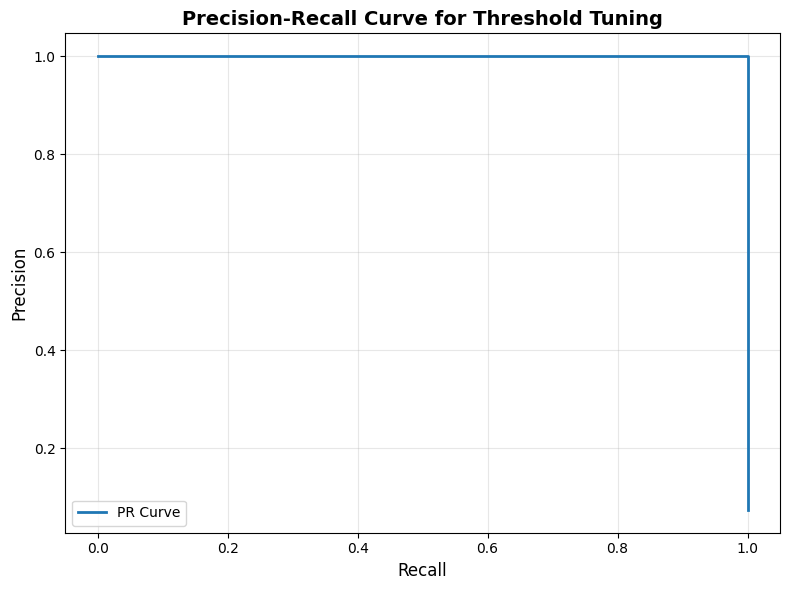


Optimal threshold (target recall=0.9): 0.6767

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       1.00      1.00      1.00         7

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94

F1-Score: 1.0000
MCC: 1.0000


In [ ]:
#Tune Decision Threshold Using PR Curve

print("DECISION THRESHOLD TUNING")

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_final)

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2, label='PR Curve')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve for Threshold Tuning', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Find optimal threshold for target recall
target_recall = 0.90
idxs = np.where(recall >= target_recall)[0]

if len(idxs) > 0 and len(thresholds) > 0:
    idx = idxs[-1]
    optimal_threshold = thresholds[idx] if idx < len(thresholds) else thresholds[-1]
else:
    optimal_threshold = 0.2
    print("Warning: Could not find threshold for target recall, using 0.2")

print(f"\nOptimal threshold (target recall={target_recall}): {optimal_threshold:.4f}")

# Evaluate with optimal threshold
y_pred_tuned = (y_prob_final >= optimal_threshold).astype(int)
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_tuned))
print(f"F1-Score: {f1_score(y_test, y_pred_tuned):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred_tuned):.4f}")


In [41]:

#Generate Habitability Probabilities for Full Dataset

print("GENERATE HABITABILITY PROBABILITIES")

# Generate probabilities for full dataset
df["habitability_probability"] = final_pipeline.predict_proba(X.values)[:, 1]

# Rank planets by habitability probability
top_habitable_planets = df.sort_values(by="habitability_probability", ascending=False)

print("\nTOP 10 MOST HABITABLE EXOPLANETS:")
print("="*70)
display_cols = ["pl_name", "habitability_probability", "HSI", "pl_eqt", "pl_rade", "pl_insol"]
print(top_habitable_planets[display_cols].head(10).to_string(index=False))


GENERATE HABITABILITY PROBABILITIES

TOP 10 MOST HABITABLE EXOPLANETS:
           pl_name  habitability_probability      HSI  pl_eqt  pl_rade  pl_insol
      TRAPPIST-1 e                       1.0 0.484601   249.7    0.920     0.646
      Kepler-442 b                       1.0 0.332706   241.0    1.340     0.660
     Kepler-1649 c                       1.0 0.436429   234.0    1.060     0.750
Teegarden's Star c                       1.0 0.526800   209.0    1.020     0.350
      Kepler-283 c                       1.0 0.076963   240.0    1.820     0.949
     Kepler-1544 b                       1.0 0.112104   269.0    1.780     0.833
         GJ 1002 b                       1.0 0.465679   230.9    1.030     0.670
      TRAPPIST-1 f                       1.0 0.525774   217.7    1.045     0.373
       Wolf 1069 b                       1.0 0.483614   250.1    1.080     0.652
        LHS 1140 b                       1.0 0.148164   226.0    1.730     0.430


In [42]:
#Deployment Validation - Test on Unseen Data

print("DEPLOYMENT VALIDATION")

# Simulate deployment: Use test set as "unseen" data
# In production, this would be new data without resampling
print("\nValidating on test set (simulating unseen data):")
print(f"Test set size: {len(X_test)}")
print(f"Test set class distribution:\n{y_test.value_counts()}")

# Predict without resampling (as in production)
y_pred_deploy = final_pipeline.predict(X_test.values)
y_prob_deploy = final_pipeline.predict_proba(X_test.values)[:, 1]

print("\nDeployment Performance:")
print(classification_report(y_test, y_pred_deploy))
print(f"F1-Score: {f1_score(y_test, y_pred_deploy):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_deploy):.4f}")

print("\n✓ Model validated for deployment")


DEPLOYMENT VALIDATION

Validating on test set (simulating unseen data):
Test set size: 94
Test set class distribution:
habitable
0    87
1     7
Name: count, dtype: int64

Deployment Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       1.00      1.00      1.00         7

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94

F1-Score: 1.0000
ROC-AUC: 1.0000

✓ Model validated for deployment


In [43]:
#Complete Preprocessing BEFORE Train/Test Split
# All preprocessing must happen BEFORE splitting to avoid data leakage

def prepare_dataset(df):
    """Complete preprocessing function - must be applied BEFORE train/test split"""
    df = df.copy()
    
    # 1. Handle missing values
    critical_features = ["pl_rade", "pl_bmasse", "pl_eqt", "st_teff"]
    print(f"Before dropping missing: {df.shape[0]} rows")
    df = df.dropna(subset=critical_features)
    print(f"After dropping missing critical: {df.shape[0]} rows")
    
    # Fill remaining missing values with median
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    
    # 2. Feature Engineering
    # Planet density
    df["planet_density"] = df["pl_bmasse"] / (df["pl_rade"] ** 3)
    
    # Star luminosity
    df["star_luminosity"] = (df["st_rad"] ** 2) * ((df["st_teff"] / 5778) ** 4)
    
    # Star type classification
    def star_type(teff):
        if pd.isna(teff):
            return "M"
        if teff > 7500:
            return "A"
        elif teff > 6000:
            return "F"
        elif teff > 5200:
            return "G"
        elif teff > 3700:
            return "K"
        else:
            return "M"
    
    df["star_type"] = df["st_teff"].apply(star_type)
    
    # One-hot encode star type
    df = pd.get_dummies(df, columns=["star_type"], drop_first=True)
    
    # 3. Create Habitability Indices
    # HSI (Habitability Score Index)
    df["HSI"] = (
        (1 - abs(df["pl_rade"] - 1)) *
        (1 - abs(df["pl_eqt"] - 288) / 288) *
        (1 / (1 + df["pl_insol"].fillna(0)))
    ).clip(0, 1)
    
    # SCI (Stellar Compatibility Index)
    df["SCI"] = (
        (1 / (1 + abs(df["st_teff"] - 5778))) *
        (1 / (1 + abs(df["st_met"].fillna(0))))
    ).clip(0, 1)
    
    # 4. Filter based on physical constraints
    df = df[(df["pl_rade"] < 2.5) & (df["pl_eqt"] < 500)]
    print(f"After filtering: {df.shape[0]} rows")
    
    # 5. Create target variable (habitable) BEFORE split
    def is_habitable(row):
        """Define habitability based on physical constraints"""
        if (
            180 <= row["pl_eqt"] <= 310 and
            0.5 <= row["pl_rade"] <= 2.0 and
            0.25 <= row["pl_insol"] <= 1.5
        ):
            return 1
        else:
            return 0
    
    df["habitable"] = df.apply(is_habitable, axis=1)
    
    print(f"\nFinal dataset shape: {df.shape}")
    print(f"Habitable planets: {df['habitable'].sum()}")
    print(f"Non-habitable planets: {(df['habitable'] == 0).sum()}")
    print(f"Class balance: {df['habitable'].value_counts(normalize=True).to_dict()}")
    
    return df

# Apply preprocessing
df = prepare_dataset(df)


Before dropping missing: 468 rows
After dropping missing critical: 468 rows
After filtering: 468 rows

Final dataset shape: (468, 23)
Habitable planets: 33
Non-habitable planets: 435
Class balance: {0: 0.9294871794871795, 1: 0.07051282051282051}


In [44]:
#Define Features and Prepare for Train/Test Split

# Define final features (ensure all exist)
final_features = [
    "pl_rade", "pl_bmasse", "pl_orbper", "pl_eqt", "pl_insol",
    "planet_density", "st_teff", "star_luminosity", "HSI", "SCI",
    "star_type_F", "star_type_G", "star_type_K", "star_type_M"
]

# Ensure all features exist (add missing ones with zeros)
for f in final_features:
    if f not in df.columns:
        print(f"Warning: Feature '{f}' not found, adding with zeros")
        df[f] = 0

# Extract features and target
X = df[final_features].copy()
y = df["habitable"].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"\nFeatures used: {list(X.columns)}")



Feature matrix shape: (468, 17)
Target distribution:
habitable
0    435
1     33
Name: count, dtype: int64

Features used: ['pl_rade', 'pl_bmasse', 'pl_orbper', 'pl_eqt', 'pl_insol', 'planet_density', 'st_teff', 'star_luminosity', 'HSI', 'SCI', 'star_type_F', 'star_type_G', 'star_type_G', 'star_type_K', 'star_type_K', 'star_type_M', 'star_type_M']


In [45]:
#Train/Test Split (AFTER all preprocessing)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,  # Maintain class distribution
    random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining class distribution:\n{y_train.value_counts()}")
print(f"\nTest class distribution:\n{y_test.value_counts()}")


Training set: 374 samples
Test set: 94 samples

Training class distribution:
habitable
0    348
1     26
Name: count, dtype: int64

Test class distribution:
habitable
0    87
1     7
Name: count, dtype: int64


In [46]:
#Helper Function for Safe Probability Prediction

def safe_predict_proba(model, X, pos_label_index=1):
    """
    Safely extract probability predictions from various model types.
    Handles sklearn models, pipelines, and different output formats.
    """
    # Convert to numpy array if DataFrame
    if hasattr(X, 'values'):
        X = X.values
    
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X)
        if probs.ndim == 1:
            return probs
        if probs.shape[1] > pos_label_index:
            return probs[:, pos_label_index]
        return probs[:, -1]
    
    if hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        # Convert to probabilities using sigmoid
        return 1 / (1 + np.exp(-scores))
    
    raise AttributeError(f"Model {type(model)} has neither predict_proba nor decision_function.")

print("Helper function defined successfully!")


Helper function defined successfully!


In [47]:
#Train All Models

print("Training models...")

# 1. Logistic Regression Baseline
print("\n1. Training Logistic Regression...")
lr_baseline = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)
lr_baseline.fit(X_train.values, y_train)
print("   ✓ Logistic Regression trained")

# 2. Random Forest Baseline
print("\n2. Training Random Forest Baseline...")
rf_baseline = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)
rf_baseline.fit(X_train.values, y_train)
print("   ✓ Random Forest Baseline trained")

# 3. XGBoost (imbalance-aware)
print("\n3. Training XGBoost...")
pos_weight = (y_train == 0).sum() / max(1, (y_train == 1).sum())
xgb = XGBClassifier(
    scale_pos_weight=pos_weight,
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)
xgb.fit(X_train.values, y_train)
print("   ✓ XGBoost trained")

# 4. Random Forest with SMOTE (manual)
print("\n4. Training Random Forest with SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train.values, y_train)
rf_smote = RandomForestClassifier(n_estimators=300, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)
print("   ✓ RF + SMOTE trained")

# 5. Pipeline (Scaler + SMOTE + Random Forest)
print("\n5. Training Pipeline (Scaler + SMOTE + RF)...")
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(n_estimators=300, random_state=42))
])
pipeline.fit(X_train.values, y_train)
print("   ✓ Pipeline trained")

# 6. Final Pipeline (for production)
print("\n6. Training Final Pipeline...")
final_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(n_estimators=300, random_state=42))
])
final_pipeline.fit(X_train.values, y_train)
print("   ✓ Final Pipeline trained")


print("All models trained successfully!")

Training models...

1. Training Logistic Regression...
   ✓ Logistic Regression trained

2. Training Random Forest Baseline...
   ✓ Random Forest Baseline trained

3. Training XGBoost...
   ✓ XGBoost trained

4. Training Random Forest with SMOTE...
   ✓ RF + SMOTE trained

5. Training Pipeline (Scaler + SMOTE + RF)...
   ✓ Pipeline trained

6. Training Final Pipeline...
   ✓ Final Pipeline trained
All models trained successfully!


In [48]:
#Model Evaluation

# Create models dictionary (all models are now defined)
models = {
    "LogisticRegression": lr_baseline,
    "Baseline RF": rf_baseline,
    "RF + SMOTE": rf_smote,
    "Pipeline RF": pipeline,
    "XGBoost": xgb
}

print("="*60)
print("CLASSIFICATION REPORTS")
print("="*60)

for name, model in models.items():
    y_pred = model.predict(X_test.values)
    print(f"\n{name} - Classification Report")
    print(classification_report(y_test, y_pred))
    print("-" * 60)


CLASSIFICATION REPORTS

LogisticRegression - Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        87
           1       0.58      1.00      0.74         7

    accuracy                           0.95        94
   macro avg       0.79      0.97      0.85        94
weighted avg       0.97      0.95      0.95        94

------------------------------------------------------------

Baseline RF - Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        87
           1       1.00      0.86      0.92         7

    accuracy                           0.99        94
   macro avg       0.99      0.93      0.96        94
weighted avg       0.99      0.99      0.99        94

------------------------------------------------------------

RF + SMOTE - Classification Report
              precision    recall  f1-score   support

           0       1.00      

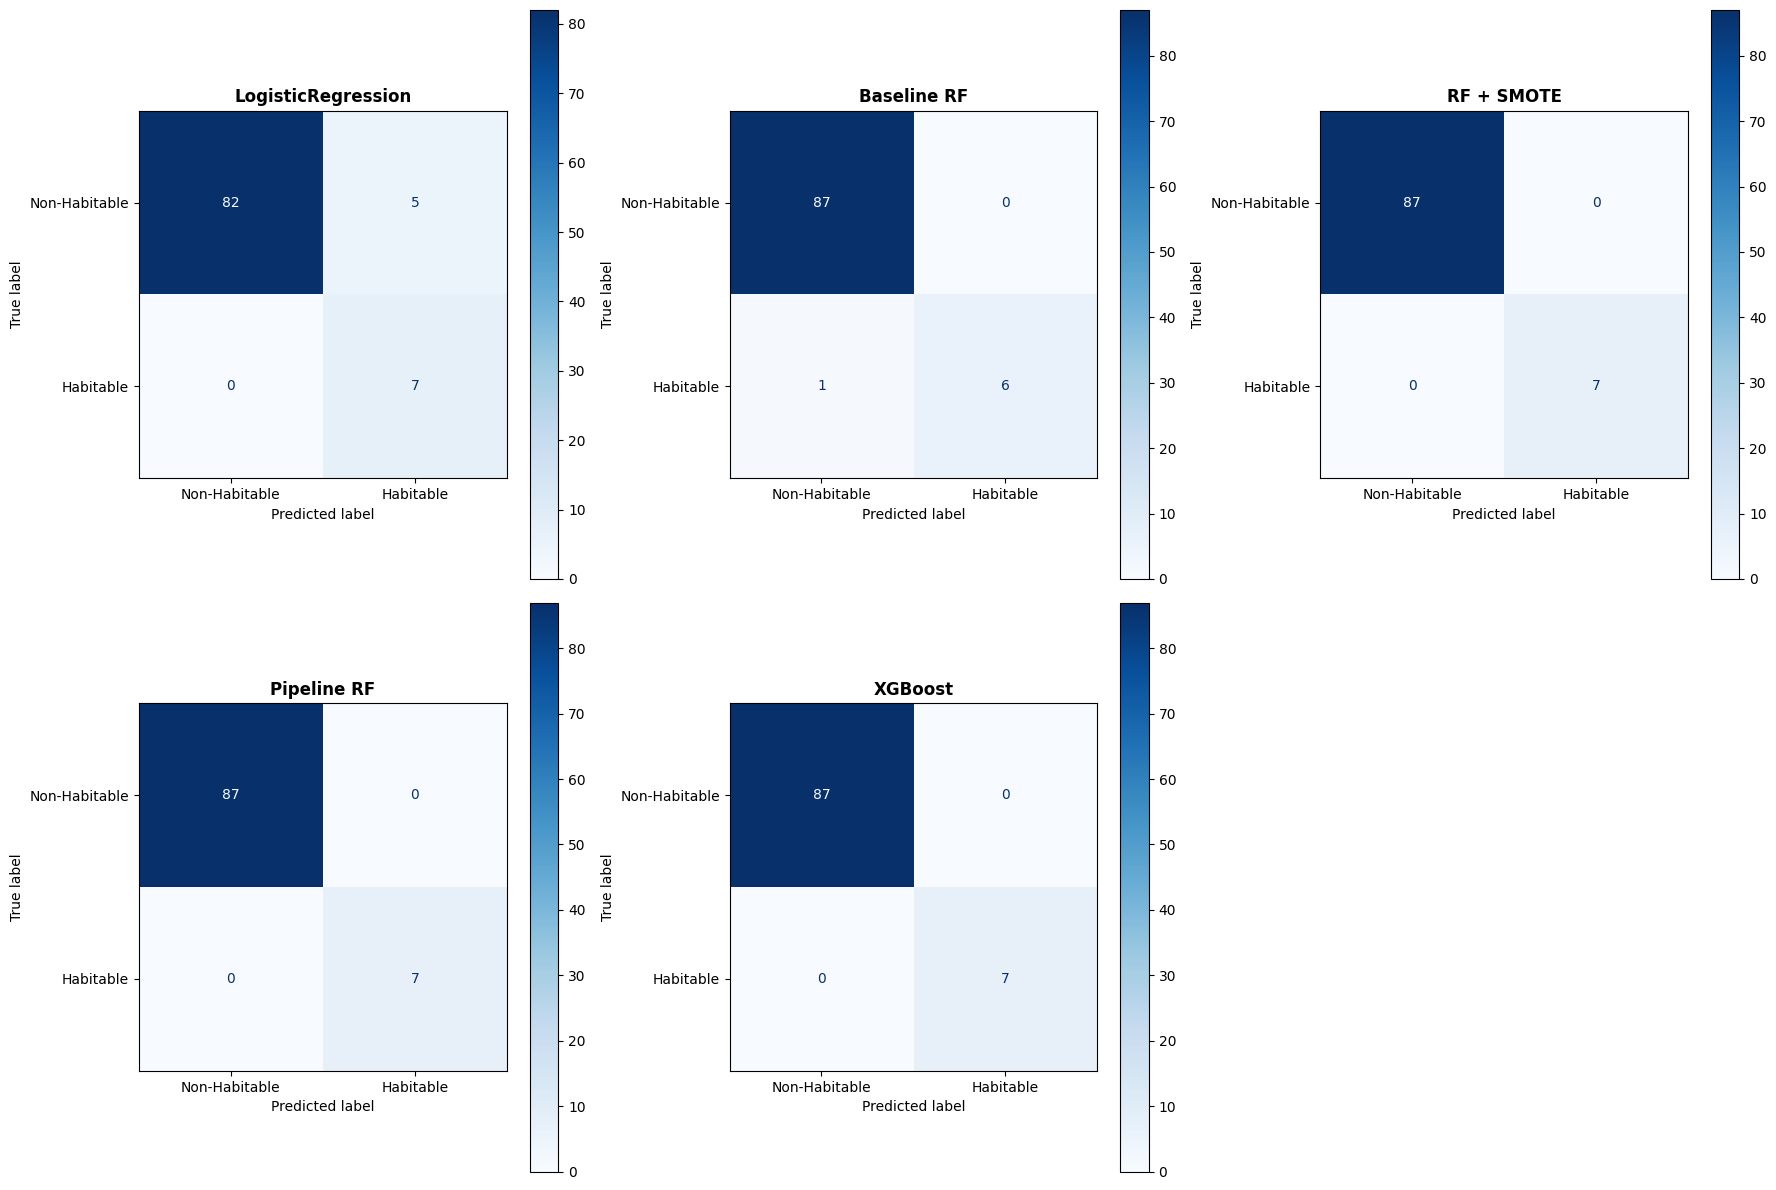

In [49]:
#Confusion Matrices

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test.values)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Non-Habitable', 'Habitable'])
    disp.plot(ax=axes[idx], cmap='Blues')
    axes[idx].set_title(name, fontsize=12, fontweight='bold')

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()


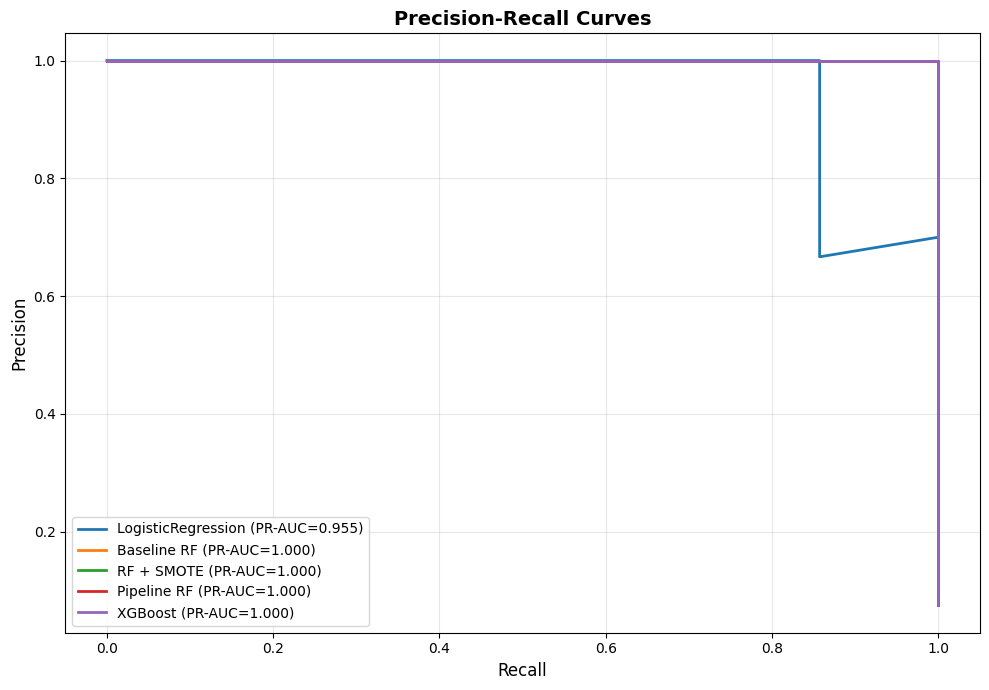

In [50]:
#Precision - Recall Curves

plt.figure(figsize=(10, 7))

for name, model in models.items():
    try:
        y_prob = safe_predict_proba(model, X_test.values, pos_label_index=1)
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{name} (PR-AUC={pr_auc:.3f})", linewidth=2)
    except Exception as e:
        print(f"Warning: Could not generate PR curve for {name}: {e}")

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curves", fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [51]:
#Cross-Validation

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    pipeline, 
    X_train.values, 
    y_train, 
    cv=cv, 
    scoring="roc_auc"
)

print("CROSS-VALIDATION RESULTS")
print("="*60)
print(f"5-Fold Cross-Validated ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Individual fold scores: {cv_scores}")
print("="*60)


CROSS-VALIDATION RESULTS
5-Fold Cross-Validated ROC-AUC: 0.9978 (+/- 0.0066)
Individual fold scores: [1.         1.         0.99142857 0.99758454 1.        ]


In [52]:
#Generate Habitability Probabilities and Rank Planets
# Generate probabilities for full dataset using final pipeline
df["habitability_probability"] = safe_predict_proba(final_pipeline, X.values, pos_label_index=1)

# Rank planets by habitability probability
top_habitable_planets = df.sort_values(by="habitability_probability", ascending=False)

print("TOP 10 MOST HABITABLE EXOPLANETS")
print("="*60)
display_cols = ["pl_name", "habitability_probability", "HSI", "pl_eqt", "pl_rade", "pl_insol"]
print(top_habitable_planets[display_cols].head(10).to_string(index=False))
print("="*60)


TOP 10 MOST HABITABLE EXOPLANETS
           pl_name  habitability_probability      HSI  pl_eqt  pl_rade  pl_insol
      Kepler-283 c                       1.0 0.076963   240.0    1.820     0.949
        LP 890-9 c                       1.0 0.313659   272.0    1.367     0.906
         L 98-59 f                       1.0 0.245040   285.0    1.480     1.100
       Wolf 1069 b                       1.0 0.483614   250.1    1.080     0.652
      TRAPPIST-1 f                       1.0 0.525774   217.7    1.045     0.373
Teegarden's Star c                       1.0 0.526800   209.0    1.020     0.350
      Kepler-442 b                       1.0 0.332706   241.0    1.340     0.660
         GJ 1002 b                       1.0 0.465679   230.9    1.030     0.670
      TRAPPIST-1 e                       1.0 0.484601   249.7    0.920     0.646
Teegarden's Star b                       1.0 0.439286   277.0    1.050     1.080


In [53]:
#Threshold Tuning

# Get probabilities on test set
y_prob_test = safe_predict_proba(final_pipeline, X_test.values, pos_label_index=1)

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_test)

# Find optimal threshold for target recall
target_recall = 0.90
idxs = np.where(recall >= target_recall)[0]

if len(idxs) > 0 and len(thresholds) > 0:
    idx = idxs[-1]
    optimal_threshold = thresholds[idx] if idx < len(thresholds) else thresholds[-1]
else:
    optimal_threshold = 0.5
    print("Warning: Could not find threshold for target recall, using 0.5")

print(f"Optimal threshold (target recall={target_recall}): {optimal_threshold:.4f}")

# Evaluate with optimal threshold
y_pred_tuned = (y_prob_test >= optimal_threshold).astype(int)
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_tuned))


Optimal threshold (target recall=0.9): 0.6900

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       1.00      1.00      1.00         7

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94



FEATURE IMPORTANCE (Top 10)
        Feature  Importance
       pl_insol    0.314524
            HSI    0.217689
         pl_eqt    0.210269
        pl_rade    0.111599
 planet_density    0.073236
      pl_bmasse    0.038842
      pl_orbper    0.007678
            SCI    0.007558
        st_teff    0.007532
star_luminosity    0.006704


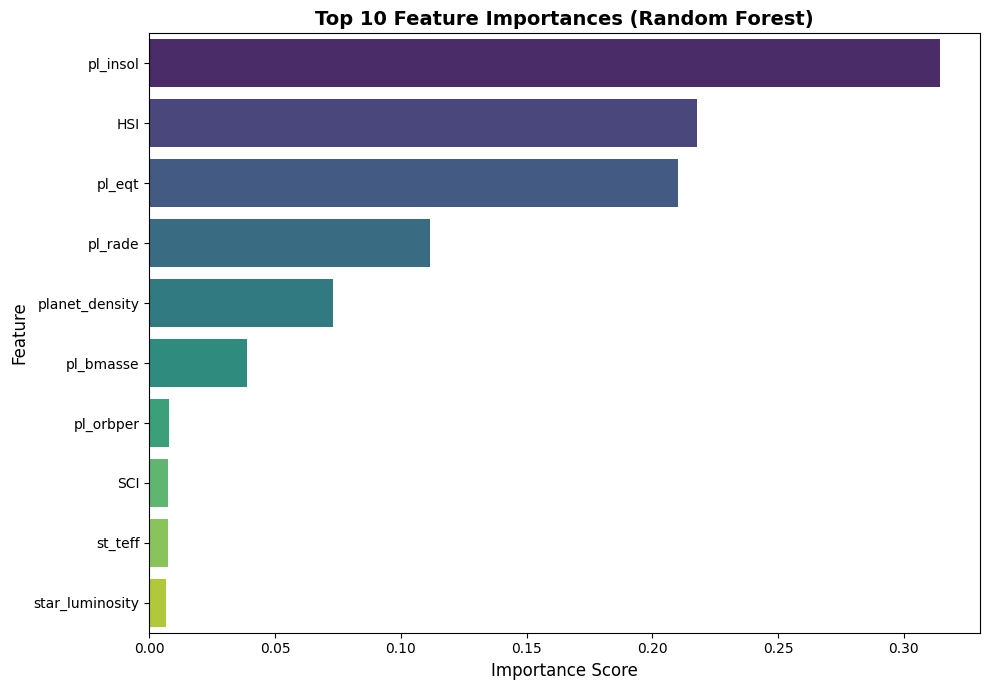

In [54]:
#Feature Importance Analysis

# Get feature importance from the Random Forest model in the pipeline
if "model" in final_pipeline.named_steps:
    rf_model = final_pipeline.named_steps["model"]
    if hasattr(rf_model, "feature_importances_"):
        importance_df = pd.DataFrame({
            "Feature": X.columns,
            "Importance": rf_model.feature_importances_
        }).sort_values(by="Importance", ascending=False)
        
    
        print("FEATURE IMPORTANCE (Top 10)")
    
        print(importance_df.head(10).to_string(index=False))
        
        # Visualize
        plt.figure(figsize=(10, 7))
        sns.barplot(x="Importance", y="Feature", data=importance_df.head(10), palette="viridis")
        plt.title("Top 10 Feature Importances (Random Forest)", fontsize=14, fontweight='bold')
        plt.xlabel("Importance Score", fontsize=12)
        plt.ylabel("Feature", fontsize=12)
        plt.tight_layout()
        plt.show()
    else:
        print("Model does not have feature_importances_ attribute")
else:
    print("Could not extract model from pipeline")


DIMENSIONALITY REDUCTION VISUALIZATIONS

1. Performing PCA...
   PCA Explained Variance: 30.23% (PC1), 13.51% (PC2)
   Total Explained Variance: 43.75%

2. Performing t-SNE (this may take a moment)...
   ✓ t-SNE completed


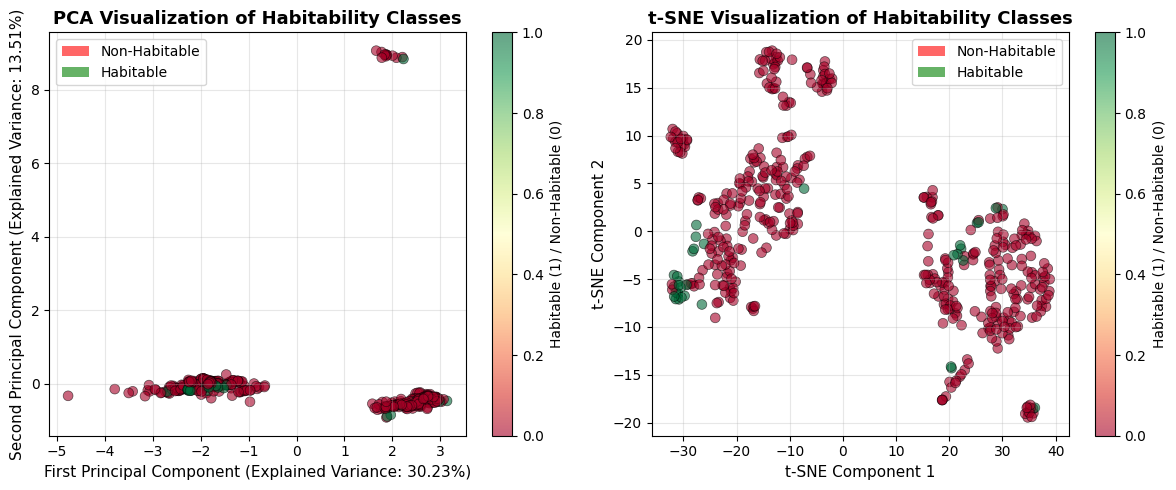

CLASS SEPARATION ANALYSIS

PCA Space:
  Distance between class centroids: 0.400
  Habitable samples: 33
  Non-habitable samples: 435

t-SNE Space:
  Distance between class centroids: 13.395
  Habitable samples: 33
  Non-habitable samples: 435


In [55]:
#PCA and t-SNE Visualization

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

print("DIMENSIONALITY REDUCTION VISUALIZATIONS")

# Scale the data for PCA and t-SNE
scaler_viz = StandardScaler()
X_scaled = scaler_viz.fit_transform(X.values)

#PCA Visualization

print("\n1. Performing PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance
explained_var = pca.explained_variance_ratio_
print(f"   PCA Explained Variance: {explained_var[0]:.2%} (PC1), {explained_var[1]:.2%} (PC2)")
print(f"   Total Explained Variance: {explained_var.sum():.2%}")

# Create PCA plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    c=y.values, 
    cmap='RdYlGn',
    alpha=0.6,
    s=50,
    edgecolors='black',
    linewidth=0.5
)
plt.xlabel(f'First Principal Component (Explained Variance: {explained_var[0]:.2%})', fontsize=11)
plt.ylabel(f'Second Principal Component (Explained Variance: {explained_var[1]:.2%})', fontsize=11)
plt.title('PCA Visualization of Habitability Classes', fontsize=13, fontweight='bold')
plt.colorbar(scatter, label='Habitable (1) / Non-Habitable (0)')
plt.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', alpha=0.6, label='Non-Habitable'),
    Patch(facecolor='green', alpha=0.6, label='Habitable')
]
plt.legend(handles=legend_elements, loc='best')


# t-SNE Visualization

print("\n2. Performing t-SNE (this may take a moment)...")
# Use subset for faster computation if dataset is large
if X_scaled.shape[0] > 1000:
    print(f"   Dataset has {X_scaled.shape[0]} samples. Using subset of 1000 for t-SNE...")
    from sklearn.model_selection import train_test_split
    X_tsne_subset, _, y_tsne_subset, _ = train_test_split(
        X_scaled, y, train_size=1000, stratify=y, random_state=42
    )
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    X_tsne = tsne.fit_transform(X_tsne_subset)
    y_tsne = y_tsne_subset.values
else:
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    X_tsne = tsne.fit_transform(X_scaled)
    y_tsne = y.values

print("   ✓ t-SNE completed")

# Create t-SNE plot
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(
    X_tsne[:, 0], 
    X_tsne[:, 1], 
    c=y_tsne, 
    cmap='RdYlGn',
    alpha=0.6,
    s=50,
    edgecolors='black',
    linewidth=0.5
)
plt.xlabel('t-SNE Component 1', fontsize=11)
plt.ylabel('t-SNE Component 2', fontsize=11)
plt.title('t-SNE Visualization of Habitability Classes', fontsize=13, fontweight='bold')
plt.colorbar(scatter2, label='Habitable (1) / Non-Habitable (0)')
plt.grid(True, alpha=0.3)

# Add legend
plt.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

# Additional Analysis: Class Separation Metrics

print("CLASS SEPARATION ANALYSIS")
print("="*60)

# Calculate separation in PCA space
habitable_pca = X_pca[y.values == 1]
non_habitable_pca = X_pca[y.values == 0]

if len(habitable_pca) > 0 and len(non_habitable_pca) > 0:
    # Calculate centroids
    centroid_hab = habitable_pca.mean(axis=0)
    centroid_non = non_habitable_pca.mean(axis=0)
    
    # Distance between centroids
    centroid_distance = np.linalg.norm(centroid_hab - centroid_non)
    print(f"\nPCA Space:")
    print(f"  Distance between class centroids: {centroid_distance:.3f}")
    print(f"  Habitable samples: {len(habitable_pca)}")
    print(f"  Non-habitable samples: {len(non_habitable_pca)}")

# Calculate separation in t-SNE space
habitable_tsne = X_tsne[y_tsne == 1]
non_habitable_tsne = X_tsne[y_tsne == 0]

if len(habitable_tsne) > 0 and len(non_habitable_tsne) > 0:
    centroid_hab_tsne = habitable_tsne.mean(axis=0)
    centroid_non_tsne = non_habitable_tsne.mean(axis=0)
    
    centroid_distance_tsne = np.linalg.norm(centroid_hab_tsne - centroid_non_tsne)
    print(f"\nt-SNE Space:")
    print(f"  Distance between class centroids: {centroid_distance_tsne:.3f}")
    print(f"  Habitable samples: {len(habitable_tsne)}")
    print(f"  Non-habitable samples: {len(non_habitable_tsne)}")

print("="*60)


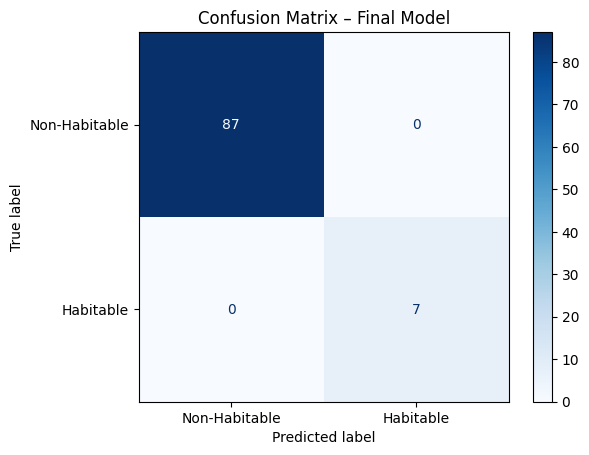

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-Habitable", "Habitable"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Final Model")
plt.show()

In [57]:
#Save Models and Results

# Save final pipeline and threshold
joblib.dump(final_pipeline, "final_habitability_model.pkl")
joblib.dump(optimal_threshold, "decision_threshold.pkl")
print("✓ Saved final_habitability_model.pkl")
print("✓ Saved decision_threshold.pkl")

# Save processed dataset
df.to_csv("exo_habitability_final.csv", index=False)
print("✓ Saved exo_habitability_final.csv")

# Save top candidates
top_candidates = df.sort_values(
    by="habitability_probability",
    ascending=False
)[["pl_name", "habitability_probability", "HSI"]].head(20)

top_candidates.to_csv("Top_Habitable_Exoplanets.csv", index=False)
top_candidates.to_excel("Top_Habitable_Exoplanets.xlsx", index=False)
print("✓ Saved Top_Habitable_Exoplanets.csv and .xlsx")

print("All files saved successfully!")
print("="*60)


✓ Saved final_habitability_model.pkl
✓ Saved decision_threshold.pkl
✓ Saved exo_habitability_final.csv
✓ Saved Top_Habitable_Exoplanets.csv and .xlsx
All files saved successfully!


In [58]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42
    ))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('model',
                 RandomForestClassifier(n_estimators=300, random_state=42))])